# Notes

This notebook updates Pipe_Creation_Plus_LSS_2.ipynb.

- It builds upon the Zhang+20 method of creating DMs from the TNG simulation.
- It improves upon this by correcting ElectronAbundance in star-forming regions using the Pakmor+18 method allowing them to be used. To do this it calculates the warm-phase gas mass fraction W (=1-X, where X is from Marinacci+17)
- It identifies LSS using the Artale+21 method.

ELECTRON DENSITY OF SFR CODE ARCHIVE

raven:/u/cwalker/Illustris_FRB_Project/oct2_2021_output/IGM_new_scripts/job_raven.py, raven:/u/cwalker/Illustris_FRB_Project/charlie_TNG_lib/charlie_TNG_tools.py
PAPERS: Marinacci+17: https://arxiv.org/abs/1610.01594, Pakmor+18: https://arxiv.org/abs/1807.02113

PIPE CREATION CODE ARCHIVE

raven:/u/cwalker/Illustris_Zhang_Method/Pipe_Creation_Test.ipynb, raven:/u/cwalker/Illustris_Zhang_Method/Pipe_Creation_Plus_LSS.ipynb, raven:/u/cwalker/Illustris_Zhang_Method/Pipe_Creation_Plus_LSS.ipynb
PAPERS: Zhang+20: https://arxiv.org/abs/2011.14494

LSS CLASSIFICATION CODE ARCHIVE

raven:/u/cwalker/Illustris_FRB_Project/git_Illustris_uploads/mass_fraction_plots/artale_test_121121/SCRIPT_Cel_Auto.py, raven:/u/cwalker/Illustris_FRB_Project/yt-artale-constants.ipynb
PAPERS: Artale+21: https://arxiv.org/abs/2102.01092


# Imports

In [136]:
import illustris_python as il
import numpy as np
from numpy import random as rand
from charlie_TNG_tools import temp2u
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import binned_statistic_dd
from astropy import constants as c
#from artale_constants import *
from astropy.cosmology import Planck15 as cosmosource


# Functions

In [137]:
def gadgetDens2SI(dens):
    """
    Original Artale function to convert TNG densities to SI units

    INPUTSRETURNS:

    dens : [values] densities from TNG

    RETURNS:

    dens converted to SI units
    """
    return dens*1E10*cel_Msol_si/cel_hubble/(cel_kpc_si/cel_hubble)**3

def TNG_Dens2SI(dens):
    """
    Like gadgetDens2SI but using astropy values for constants
    Strips result of units
    Developed in raven:/u/cwalker/Illustris_FRB_Project/yt-artale-constants.ipynb


    INPUTSRETURNS:

    dens : [values] densities from TNG

    RETURNS:

    dens converted to SI units
    """
    return dens*1E10*c.M_sun.to('kg').value/cosmosource.h/(c.kpc.to('m').value/cosmosource.h)**3

def TNG_Dens2SI_astropy(dens):
    """
    Like TNG_Dens2SI but does not strip result of units.
    Developed in raven:/u/cwalker/Illustris_FRB_Project/yt-artale-constants.ipynb


    INPUTSRETURNS:

    dens : [values] densities from TNG

    RETURNS:

    dens converted to SI units
    """

    return dens*1E10*c.M_sun.to('kg')/cosmosource.h/(c.kpc.to('m')/cosmosource.h)**3

   
    
    


# Begin

From paper:

"For computational simplicity, the line of sight is chosen parallel
to the X-axis, which is similar to Jaroszynski+19"

"Then we make 5125 square pipes with 200ckpc/h side in each snapshot
and find the particles as well as necessary parameters including
Coordinates, Density, ElectronAbundance, GFM_Metals, and StarFormationRate.
The 5125 pipes are chosen from different locations at 24 snapshots randomly"

"We divide the pipe into
10,000 bins along the x axis and take the geometric center coordinates as the representation of bins."

"We take an average of the electron density
of 10,000 bins and put it into equation (7). As a result,
5125 dDMIGM/dz are obtained at each redshift."





# Step: load data and initialise

In [138]:
npipes      = 1  #number of pipes to create
snap_number = 99 #snapshot number for test

###########
#load data#
###########

#simulation to use
sim_to_use = 'TNG100-3'
#base path to simulation
basePath = '/ptmp/cwalker/Illustris_FRB_Project/TNG_copies/virgo/simulations/IllustrisTNG/{0}/output/'.format(sim_to_use)
basePath = '/virgo/simulations/IllustrisTNG/{0}/output/'.format(sim_to_use)

print('Loading Simulation: {0}'.format(sim_to_use))
#gas, i.e. partType0 data to load
dataPT0 = il.snapshot.loadSubset(basePath, snap_number, 'gas', fields=['Density',
                                                                       'ElectronAbundance',
                                                                       'StarFormationRate',
                                                                       'InternalEnergy',
                                                                       'Coordinates',
                                                                       'Masses',
                                                                       'SubfindDMDensity'])


######################################
#create warm-phase gas mass fractions#
######################################
#note: this is from _w_frac_new() function in 
#raven:/u/cwalker/Illustris_FRB_Project/oct2_2021_output/IGM_new_scripts/job_raven.py

density = dataPT0['Density'] #the density values along the light ray in gcm**-3
sfr     = dataPT0['StarFormationRate'] #the star formation rate along the light ray in g/s
ie      = dataPT0['InternalEnergy'] #the internal energy along the light ray in erg/g
ea      = dataPT0['ElectronAbundance'] #the electron abundance along the light ray

#define constants
T_h = 10**7  #hot phase gase temperature [Kelvin] 
T_c = 10**3  #cold phase gas temperature [Kelvin]
x_h = 0.75   #Hydrogen mass fraction


#calculate x and w, cold and warm phase gas mass fractions
x_frac = (temp2u(T_h,ea)-ie)/(temp2u(T_h,ea)-temp2u(T_c,ea)) #cold phase mass fraction
w_frac = 1 - x_frac # warm phase mass fraction

#only modify electron abundance if sfr = 0
w_frac[np.where(sfr==0)]=1

#append to the data dictionary
dataPT0['Warm'] = w_frac



#load header
header = il.groupcat.loadHeader(basePath,snap_number)

print(header)
print(dataPT0['Coordinates'].shape)
print(dataPT0['Warm'].shape)
#print(dataPT4['Coordinates'].shape)

Loading Simulation: TNG100-3
{'BoxSize': 75000.0, 'FlagDoubleprecision': 0, 'Git_commit': b'd203ec8b07c7e2bdda5f608aa0babea46d603699', 'Git_date': b'Thu Apr 7 14:14:27 2016 +0200', 'HubbleParam': 0.6774, 'Ngroups_ThisFile': 15, 'Ngroups_Total': 124773, 'Nids_ThisFile': 10358237, 'Nids_Total': 72200157, 'Nsubgroups_ThisFile': 3870, 'Nsubgroups_Total': 118820, 'NumFiles': 7, 'Omega0': 0.3089, 'OmegaLambda': 0.6911, 'Redshift': 2.220446049250313e-16, 'Time': 0.9999999999999998}
(88935326, 3)
(88935326,)


# Sanity check: plot the mass fractions

(x should lie between 0.9 and 1)

[-2.46861537 -3.04114825 -2.70703082 ...  0.99818629  0.99556796
 -5.4297305 ]


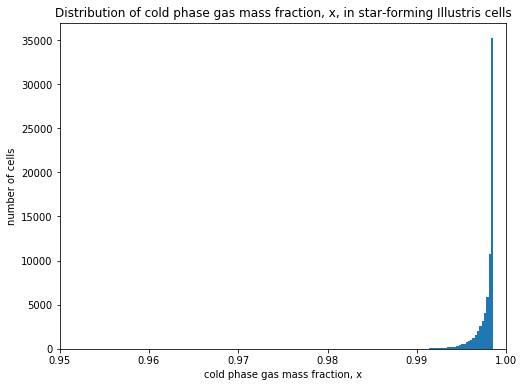

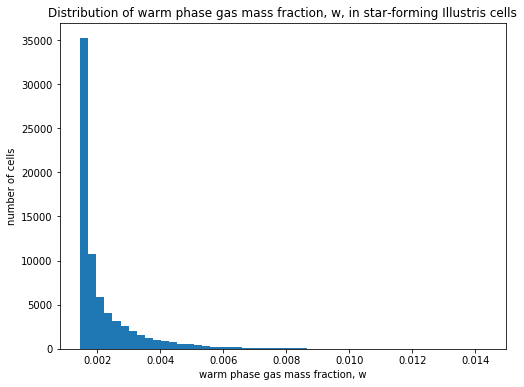

In [139]:
#check the mass fractions
print(x_frac)
fig=plt.figure(figsize=(8,6))
ax=fig.add_subplot(111)
ax.set_title('Distribution of cold phase gas mass fraction, x, in star-forming Illustris cells')
ax.set_xlabel('cold phase gas mass fraction, x')
ax.set_ylabel('number of cells')
ax.set_xlim([0.95,1.0])
ax.hist(x_frac[np.where(dataPT0['StarFormationRate']!=0)],bins=50)
plt.show()
fig=plt.figure(figsize=(8,6))
ax=fig.add_subplot(111)
ax.set_title('Distribution of warm phase gas mass fraction, w, in star-forming Illustris cells')
ax.set_xlabel('warm phase gas mass fraction, w')
ax.set_ylabel('number of cells')
#ax.set_xlim([0.0,0.1])
ax.hist(dataPT0['Warm'][np.where(dataPT0['StarFormationRate']!=0)],bins=50)
plt.show()

In [140]:
print(dataPT0)
print(dataPT0['Coordinates'])
print(dataPT0['Density'].shape)
print(dataPT0['Coordinates'].shape)
print(dataPT0['Warm'].shape)
print(header['Redshift'])
print(TNG_Dens2SI_astropy(dataPT0['Density']))
print(cosmosource.H(0))
print(c.c*1)
print((c.c*1)/(cosmosource.H(0)))




{'count': 88935326, 'Density': array([4.4757024e-05, 4.2580104e-05, 4.0865103e-05, ..., 1.0396706e-08,
       3.8186054e-09, 6.2579730e-08], dtype=float32), 'ElectronAbundance': array([1.1720068, 1.169845 , 1.1741027, ..., 1.1565148, 1.157627 ,
       1.1586834], dtype=float32), 'StarFormationRate': array([0., 0., 0., ..., 0., 0., 0.], dtype=float32), 'InternalEnergy': array([7.3468975e+05, 8.5513269e+05, 7.8591825e+05, ..., 4.0254480e+02,
       9.5377710e+02, 1.3538065e+06], dtype=float32), 'Coordinates': array([[  870.53536263, 26340.14797967, 18286.47294083],
       [  866.458565  , 26333.73134483, 18284.21846164],
       [  873.48149066, 26332.11977328, 18286.97684438],
       ...,
       [69235.22286862, 32512.26227586, 41876.47687281],
       [74189.36807862, 32759.88182406, 44010.40573232],
       [20071.25734025, 46529.37972099, 49350.65699391]]), 'Masses': array([0.00960091, 0.01044808, 0.00629255, ..., 0.00623366, 0.00766651,
       0.00503381], dtype=float32), 'SubfindDMDen

/mpcdf/soft/SLE_15/packages/x86_64/anaconda/3/2020.02/lib/python3.7/site-packages/astropy/units/quantity.py:481: RuntimeWarning: overflow encountered in multiply
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mpcdf/soft/SLE_15/packages/x86_64/anaconda/3/2020.02/lib/python3.7/site-packages/astropy/units/quantity.py:481: RuntimeWarning: overflow encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


[1.38997155e-23 1.32236514e-23 1.26910422e-23 ... 3.22879459e-27
 1.18590377e-27 1.94347242e-26] kg / m3
67.74 km / (Mpc s)
299792458.0 m / s
4425634.16002362 m Mpc / km


In [141]:
#averages test
sample = np.arange(30)
print(sample,np.mean(sample))
reshaped = sample.reshape(3,10)
print(reshaped,np.mean(reshaped,axis=1),np.sum(np.mean(reshaped,axis=1)),np.mean(np.mean(reshaped,axis=1)))
reshaped2 = np.array([np.array([0,1,2,3,4,5]),np.array([6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21]),np.array([22,23,24,25,26,27,28,29])])
print(reshaped2,np.array([np.mean(reshaped2[0]),np.mean(reshaped2[1])]))

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29] 14.5
[[ 0  1  2  3  4  5  6  7  8  9]
 [10 11 12 13 14 15 16 17 18 19]
 [20 21 22 23 24 25 26 27 28 29]] [ 4.5 14.5 24.5] 43.5 14.5
[array([0, 1, 2, 3, 4, 5])
 array([ 6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21])
 array([22, 23, 24, 25, 26, 27, 28, 29])] [ 2.5 13.5]


# Test 1: create dDM/dz values for each type of structure directly

In [142]:

############
#initialise#
############

#The number of cells in the chosen snapshot
ncells = dataPT0['Coordinates'].shape[0]
print('Number of cells in snapshot {0} is {1}'.format(snap_number,ncells))

#The width of the pipe
pipe_width = 200 #By following zhang+20 definition, sides will be 200ckpc/h in length
print('Pipe width will be {0} ckpc/h'.format(pipe_width))

#The number of bins along a single line of sight
nbins=10000 #Zhang+20 definition: 10,000
print('There will be {0} bins on each sightline'.format(nbins))

#Define the mass of a proton for dDM/dz calculations
protonmass = c.m_p.to('kg')
print('Proton mass is {0}'.format(protonmass))

#Define the hydrogen mass fraction for dDM/dz calculations
hmassfrac = 3./4.
print('Chosen H mass fraction is {0}. Check whether this is correct'.format(hmassfrac))

#calculate the critical density at redshift zero for structure categorisation
#source to formula: https://astronomy.swin.edu.au/cosmos/c/Critical+Density
grav=c.G.to('m**3/(kg*s**2)') #g as a YT quantity in correct units
H=cosmosource.H(0).to('km/s/Mpc') #hubble const at z=0 in km/s/Mpc
my_dens_crit = ((3 * H**2)/(8*np.pi* grav)).to('kg/m**3')
print('Critical density at z=0 = {0}'.format(my_dens_crit))




Number of cells in snapshot 99 is 88935326
Pipe width will be 200 ckpc/h
There will be 10000 bins on each sightline
Proton mass is 1.67262192369e-27 kg
Chosen H mass fraction is 0.75. Check whether this is correct
Critical density at z=0 = 8.619160453152573e-27 kg / m3


Creating pipe 0
Random start cell coordinates: [    0.         30797.53485246 63616.71379773]
Pipe end cell coordinates: [75000.         30797.53485246 63616.71379773]
[(0.0, 75000.0), (30797.534852456083, 30797.534852456083), (63616.713797725075, 63616.713797725075)]
All y and z values: [[26340.14797967 18286.47294083]
 [26333.73134483 18284.21846164]
 [26332.11977328 18286.97684438]
 ...
 [32512.26227586 41876.47687281]
 [32759.88182406 44010.40573232]
 [46529.37972099 49350.65699391]]
Upper right: [30897.53485246 63716.71379773]
Lower left: [30697.53485246 63516.71379773]
483 cells in this pipe
sum for star forming check: 0.0
Number of cells in Zhang method pipe: (483,)
Number of cells in Pakmor method pipe: (483,)
Pipe x-axis bin coordinates: [0.00000000e+00 7.50075008e+00 1.50015002e+01 ... 7.49849985e+04
 7.49924992e+04 7.50000000e+04] ckpc/h
Pipe x-bin_coords: [[0.00000000e+00 3.07975349e+04 6.36167138e+04]
 [7.50075008e+00 3.07975349e+04 6.36167138e+04]
 [1.50015002e+01 3.07975

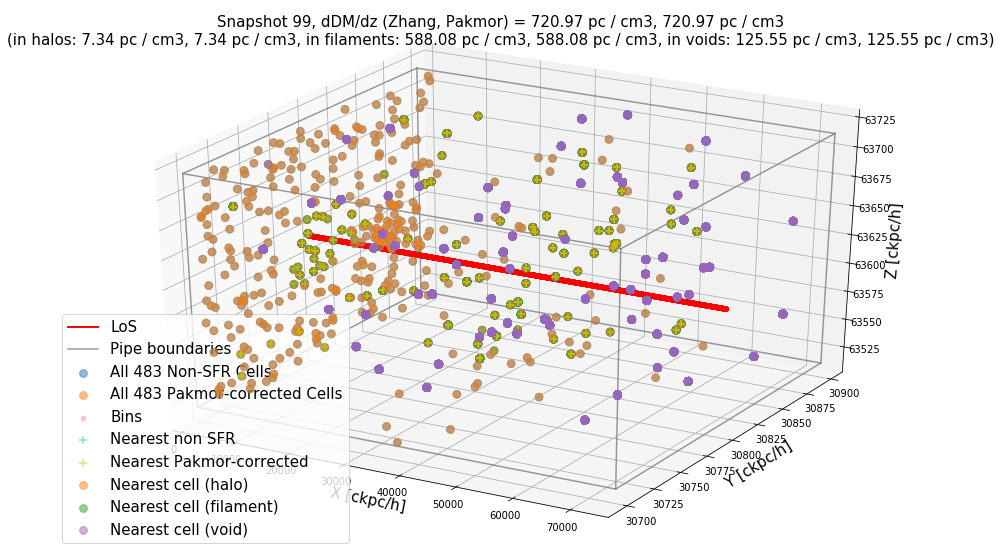

In [143]:
###################
#initialise figure#
###################

fig = plt.figure(figsize=(16,10))
ax = fig.add_subplot(111,projection='3d')
ax.set_xlim(0,header['BoxSize'])
ax.set_xlabel('X [ckpc/h]',fontsize=15)
ax.set_ylabel('Y [ckpc/h]',fontsize=15)
ax.set_zlabel('Z [ckpc/h]',fontsize=15)

#############
#Create Pipe#
#############

for i in range(npipes): #for each desired pipe
    
    pipe_number = i
    print('Creating pipe {0}'.format(pipe_number))

    #########################################
    #define los coordinates at start of pipe#
    #########################################
    
    #By Zhang+20 definition of following x-axis,
    #x will be zero, y and z will be random
    #units default = ckpc/h (compare box size to https://www.tng-project.org/about/)
    
    pipe_start_coords = np.array([0,
                         np.random.uniform(0,header['BoxSize'],1)[0],
                         np.random.uniform(0,header['BoxSize'],1)[0]])
    print('Random start cell coordinates: {0}'.format(pipe_start_coords))
    
    ###################################
    #define coordinates at end of pipe#
    ###################################
    
    #By Zhang+20 definition of following x-axis,
    #x will be length of simulation,y and z will be same as start coords
    
    pipe_end_coords = pipe_start_coords+np.array([header['BoxSize'],0,0])
    print('Pipe end cell coordinates: {0}'.format(pipe_end_coords))

    ########################
    #plot the line of sight#
    ########################
    
    los_toplot=list(zip(pipe_start_coords,pipe_end_coords))
    print(los_toplot)
    ax.plot(los_toplot[0],
            los_toplot[1],
            los_toplot[2],
            color='r',lw=2,label='LoS')
    
    ########################
    #construct pipe corners#
    ########################
    
    #Add and subtract half of pipe length from y and z coords for y and z boundaries
    #code adapted from https://stackoverflow.com/questions/33540109/plot-surfaces-on-a-cube
    
    c1s = pipe_start_coords + np.array([0,pipe_width/2,pipe_width/2]) #start corner 1
    c2s = pipe_start_coords + np.array([0,-pipe_width/2,-pipe_width/2]) #start corner 2
    c3s = pipe_start_coords + np.array([0,pipe_width/2,-pipe_width/2]) #start corner 3
    c4s = pipe_start_coords + np.array([0,-pipe_width/2,pipe_width/2]) #start corner 4
    
    c1e = pipe_end_coords + np.array([0,pipe_width/2,pipe_width/2]) #end corner 1
    c2e = pipe_end_coords + np.array([0,-pipe_width/2,-pipe_width/2]) #end corner 2
    c3e = pipe_end_coords + np.array([0,pipe_width/2,-pipe_width/2]) #end corner 3
    c4e = pipe_end_coords + np.array([0,-pipe_width/2,pipe_width/2]) #end corner 4
    
    corners = np.array([c1s,c2s,c3s,c4s,c1e,c2e,c3e,c4e])
    
    ######################
    #construct pipe edges#
    ######################

    line1 = list(zip(c1s,c1e))
    line2 = list(zip(c2s,c2e))
    line3 = list(zip(c3s,c3e))
    line4 = list(zip(c4s,c4e))
    line5 = list(zip(c1s,c3s))
    line6 = list(zip(c3s,c2s))
    line7 = list(zip(c2s,c4s))
    line8 = list(zip(c4s,c1s))
    line9 = list(zip(c1e,c3e))
    line10 = list(zip(c3e,c2e))
    line11 = list(zip(c2e,c4e))
    line12 = list(zip(c4e,c1e))
    
    lines_todraw = np.array([line1,line2,line3,line4,line5,line6,line7,line8,line9,line10,line11,line12])
    

    ###########
    #plot pipe#
    ###########
    
    for i in range(len(lines_todraw)):
        if i==0:
            ax.plot(lines_todraw[i][0],
                    lines_todraw[i][1],
                    lines_todraw[i][2],
                    color='gray',alpha=0.8,label='Pipe boundaries')
        else:
            ax.plot(lines_todraw[i][0],
                    lines_todraw[i][1],
                    lines_todraw[i][2],
                    color='gray',alpha=0.8)

    ########################
    #get cells in this pipe#
    ########################
    
    #adapted from https://stackoverflow.com/questions/42352622/finding-points-within-a-bounding-box-with-numpy
    #I think this is right but if I get any strange results, double check the theory
    
    yz_pts = dataPT0['Coordinates'][:,[1,2]] #all y and z coords
    print('All y and z values: {0}'.format(yz_pts))

    ur = c1s[1:] #upper right of pipe start (y and z only)
    ll = c2e[1:] #lower left of pipe end (y and z only)
    print('Upper right: {0}'.format(ur))
    print('Lower left: {0}'.format(ll))

    inidx = np.all((ll <= yz_pts) & (yz_pts <= ur), axis=1) #indexes of cells in pipe
    
    ###########################
    #get data of cells in pipe#
    ###########################
    
    pipe_cell_coords = dataPT0['Coordinates'][inidx]       #coordinates [ckpc/h]
    pipe_cell_dens   = dataPT0['Density'][inidx]           #densities [(1e10Msun/h)/(ckpc/h)**3]
    pipe_cell_elab   = dataPT0['ElectronAbundance'][inidx] #electron abundance [-]
    pipe_cell_sfr    = dataPT0['StarFormationRate'][inidx] #star formation rate [Msun/yr]
    pipe_cell_dark   = dataPT0['SubfindDMDensity'][inidx]  #comoving dark matter density [(1e10Msun/h)/(ckpc/h)**3]
    pipe_cell_warm   = dataPT0['Warm'][inidx]              #warm-phase gas mass fraction
    
    print('{0} cells in this pipe'.format(dataPT0['Coordinates'][inidx].shape[0]))

    ###############################
    #plot locations of these cells#
    ###############################
    
    #ax.scatter3D(pipe_cell_coords[:,0],
    #             pipe_cell_coords[:,1],
    #             pipe_cell_coords[:,2],
    #             label='Cells',s=60)
    
    
    ############################################################
    #For pure Zhang+20 method, exclude all star forming regions#
    ############################################################
    
    pipe_cell_coords_z = pipe_cell_coords[np.where(pipe_cell_sfr==0)]
    pipe_cell_dens_z = pipe_cell_dens[np.where(pipe_cell_sfr==0)]
    pipe_cell_elab_z = pipe_cell_elab[np.where(pipe_cell_sfr==0)]
    pipe_cell_sfr_z = pipe_cell_sfr[np.where(pipe_cell_sfr==0)]
    pipe_cell_dark_z = pipe_cell_dark[np.where(pipe_cell_sfr==0)]
    
    print('sum for star forming check: {0}'.format(pipe_cell_sfr_z.sum()))
    print('Number of cells in Zhang method pipe: {0}'.format(pipe_cell_dens_z.shape))
    
    #############################################################################################
    #For Pakmor+18 method, apply correction to A for star forming regions and leave no cells out#
    #############################################################################################
    
    pipe_cell_coords_p = pipe_cell_coords[:]
    pipe_cell_dens_p   = pipe_cell_dens[:]
    pipe_cell_elab_p   = pipe_cell_elab[:]*pipe_cell_warm[:] #perform Pakmor correction
    pipe_cell_sfr_p    = pipe_cell_sfr[:]
    pipe_cell_dark_p   = pipe_cell_dark[:]
    print('Number of cells in Pakmor method pipe: {0}'.format(pipe_cell_dens_p.shape))

    ###############################
    #plot locations of these cells#
    ###############################
    
    ax.scatter3D(pipe_cell_coords_z[:,0],
                 pipe_cell_coords_z[:,1],
                 pipe_cell_coords_z[:,2],
                 label='All {0} Non-SFR Cells'.format(len(pipe_cell_coords_z)),s=60,color='C0',marker='o',alpha=0.5)
    
    ax.scatter3D(pipe_cell_coords_p[:,0],
                 pipe_cell_coords_p[:,1],
                 pipe_cell_coords_p[:,2],
                 label='All {0} Pakmor-corrected Cells'.format(len(pipe_cell_coords_p)),s=60,color='C1',marker='o',alpha=0.5)
    
    ###############################################
    #divide pipe into 10,000 bins along the x-axis#
    ###############################################
    
    #Question: why 10,000 bins given there are so few particles in the pipe?
    
    pipe_x_bins = np.linspace(pipe_start_coords[0],pipe_end_coords[0],nbins)
    print('Pipe x-axis bin coordinates: {0} ckpc/h'.format(pipe_x_bins))
    
    #######################################
    #get coordinates of center of each bin#
    #######################################
    
    pipe_bin_coords = np.array([[i,pipe_start_coords[1],pipe_start_coords[2]]for i in pipe_x_bins])
    print('Pipe x-bin_coords: {0}'.format(pipe_bin_coords))
    
    #plot locations of these bins
    ax.scatter3D(pipe_bin_coords[:,0],
             pipe_bin_coords[:,1],
             pipe_bin_coords[:,2],
             label='Bins',color='r',alpha=0.2)
    
    ###############################################################
    #for each bin, find distance between it and every cell in pipe#
    #find the one with miniimum distance                          #
    #this will be the cell in the los                             #
    #do for zhang (excluding sfr) and Pakmor (including sfr)      #
    ###############################################################
    
    ###########
    #Pakmor   #
    ###########
    
    #initialise empty array to hold indices of closest particle to each bin
    nearest_idxs_p = []
    
    for i in range(len(pipe_bin_coords)): #loop over bins
        coords = pipe_bin_coords[i] #get bin coordinates
        distarr = np.sqrt(np.sum(((pipe_cell_coords_p[:]-coords)**2),axis=1)) #create array of distances from cells
        nearest = np.argmin(distarr) #find nearest cell to bin
        nearest_idxs_p.append(nearest) #append to array
        
    nearest_idxs_p = np.array(nearest_idxs_p) #convert to numpy array
    nearest_idxs_unique_p = np.unique(nearest_idxs_p) #some cells are the closest to multiple bins. Get uniques.
    
    ##############
    #zhang method#
    ##############
    
    #initialise empty array to hold indices of closest particle to each bin
    nearest_idxs_z = []
    
    for i in range(len(pipe_bin_coords)): #loop over bins
        coords = pipe_bin_coords[i] #get bin coordinates
        distarr = np.sqrt(np.sum(((pipe_cell_coords_z[:]-coords)**2),axis=1)) #create array of distances from cells
        nearest = np.argmin(distarr) #find nearest cell to bin
        nearest_idxs_z.append(nearest) #append to array
        
    nearest_idxs_z = np.array(nearest_idxs_z) #convert to numpy array
    nearest_idxs_unique_z = np.unique(nearest_idxs_z) #some cells are the closest to multiple bins. Get uniques.
    
    print('Nearest {0} particle ids: {1}'.format(np.shape(nearest_idxs_p),nearest_idxs_p))
    print('Of these, {0} are unique: {1}'.format(np.shape(nearest_idxs_unique_p),nearest_idxs_unique_p))
    
    #################################
    #extract data from nearest cells#
    #################################
    
    ###########
    #Pakmor   #
    ###########
    
    pipe_nearest_coords_p = np.array(pipe_cell_coords_p[nearest_idxs_p]) #coordinates [ckpc/h]
    pipe_nearest_dens_p   = np.array(pipe_cell_dens_p[nearest_idxs_p])   #densities [(1e10Msun/h)/(ckpc/h)**3]
    pipe_nearest_elab_p   = np.array(pipe_cell_elab_p[nearest_idxs_p])   #electron abundance [-]
    pipe_nearest_sfr_p    = np.array(pipe_cell_sfr_p[nearest_idxs_p])    #star formation rate [Msun/yr]
    pipe_nearest_dark_p   = np.array(pipe_cell_dark_p[nearest_idxs_p])   #comooving dark matter density [(1e10Msun/h)/(ckpc/h)**3]
    
    #######
    #zhang#
    #######
    pipe_nearest_coords_z = np.array(pipe_cell_coords_z[nearest_idxs_z]) #coordinates [ckpc/h]
    pipe_nearest_dens_z   = np.array(pipe_cell_dens_z[nearest_idxs_z])   #densities [(1e10Msun/h)/(ckpc/h)**3]
    pipe_nearest_elab_z   = np.array(pipe_cell_elab_z[nearest_idxs_z])   #electron abundance [-]
    pipe_nearest_sfr_z    = np.array(pipe_cell_sfr_z[nearest_idxs_z])    #star formation rate [Msun/yr]
    pipe_nearest_dark_z   = np.array(pipe_cell_dark_z[nearest_idxs_z])   #comooving dark matter density [(1e10Msun/h)/(ckpc/h)**3]
    
    #mark locations of nearest cells to bins on plot
    #ax.scatter3D(pipe_nearest_coords[:,0],
    #         pipe_nearest_coords[:,1],
    #         pipe_nearest_coords[:,2],
    #         label='Nearest',color='k',marker='x',s=50)
    
    ax.scatter3D(pipe_nearest_coords_z[:,0],
             pipe_nearest_coords_z[:,1],
             pipe_nearest_coords_z[:,2],
             label='Nearest non SFR',color='C',marker='+',s=50,alpha=0.5)
    
    ax.scatter3D(pipe_nearest_coords_p[:,0],
             pipe_nearest_coords_p[:,1],
             pipe_nearest_coords_p[:,2],
             label='Nearest Pakmor-corrected',color='Y',marker='+',s=50,alpha=0.5)

    ###############################################
    #convert density to si units using artale code#
    ###############################################
    
    pipe_nearest_dens_p_si = TNG_Dens2SI_astropy(pipe_nearest_dens_p)    
    pipe_nearest_dens_z_si = TNG_Dens2SI_astropy(pipe_nearest_dens_z)
    
    ###########################################################
    #convert dark matter density to si units using artale code#
    ###########################################################
    
    pipe_nearest_dark_p_si = TNG_Dens2SI_astropy(pipe_nearest_dark_p)    
    pipe_nearest_dark_z_si = TNG_Dens2SI_astropy(pipe_nearest_dark_z) 
    
    #########################################################################
    #divide dark matter density by critical density to create the LSS tracer#
    #########################################################################
    
    pipe_nearest_LSStracer_p = pipe_nearest_dark_p_si/my_dens_crit
    pipe_nearest_LSStracer_z = pipe_nearest_dark_z_si/my_dens_crit
    print('The structure tracer array is {0}'.format(pipe_nearest_LSStracer_z))
    
    ##########################################
    #Create Large-Scale Structure (LSS) masks#
    ##########################################
    
    #Pakmor
    voi_mask_PT0_p = pipe_nearest_LSStracer_p < 0.1
    fil_mask_PT0_p = np.logical_and(pipe_nearest_LSStracer_p >= 0.1, pipe_nearest_LSStracer_p < 57)#CELESTE:CORRECTED
    hal_mask_PT0_p = pipe_nearest_LSStracer_p >= 57 
    
    #zhang
    voi_mask_PT0_z = pipe_nearest_LSStracer_z < 0.1
    fil_mask_PT0_z = np.logical_and(pipe_nearest_LSStracer_z >= 0.1, pipe_nearest_LSStracer_z < 57)#CELESTE:CORRECTED
    hal_mask_PT0_z = pipe_nearest_LSStracer_z >= 57 
    
    #################################################
    #plot each structure type as a separate colour#
    #################################################
    
    #halos
    ax.scatter3D(pipe_nearest_coords_z[hal_mask_PT0_z][:,0],
             pipe_nearest_coords_z[hal_mask_PT0_z][:,1],
             pipe_nearest_coords_z[hal_mask_PT0_z][:,2],
             label='Nearest cell (halo)',color='C1',marker='o',s=60,alpha=0.5)

    #filaments
    ax.scatter3D(pipe_nearest_coords_z[fil_mask_PT0_z][:,0],
             pipe_nearest_coords_z[fil_mask_PT0_z][:,1],
             pipe_nearest_coords_z[fil_mask_PT0_z][:,2],
             label='Nearest cell (filament)',color='C2',marker='o',s=60,alpha=0.5)
    
    #voids
    ax.scatter3D(pipe_nearest_coords_z[voi_mask_PT0_z][:,0],
             pipe_nearest_coords_z[voi_mask_PT0_z][:,1],
             pipe_nearest_coords_z[voi_mask_PT0_z][:,2],
             label='Nearest cell (void)',color='C4',marker='o',s=60,alpha=0.5)
    
    ##########################################
    #get electron density at each of the bins#
    ##########################################
    
    #follow zhang+20 equation exactly as native units of TNG are
    #comoving
    
    #############################################################
    #Zhang: pne = (ElAb)*hmasssfrac*(Dens/protonmass)*((1+z)**3)#
    #use data which excludes SFRs                               #
    #############################################################
    
    #total
    pipe_nearest_pne_z = (pipe_nearest_elab_z)*hmassfrac*(pipe_nearest_dens_z_si/protonmass)*((1+header['Redshift'])**3)
    pipe_nearest_pne_p = (pipe_nearest_elab_p)*hmassfrac*(pipe_nearest_dens_p_si/protonmass)*((1+header['Redshift'])**3)
    print('Zhang pnes are: {0}'.format(pipe_nearest_pne_z))
    print('Pakmor-corrected pnes are: {0}'.format(pipe_nearest_pne_p))

    #halos
    pipe_nearest_pne_z_hal = (pipe_nearest_elab_z[hal_mask_PT0_z])*hmassfrac*(pipe_nearest_dens_z_si[hal_mask_PT0_z]/protonmass)*((1+header['Redshift'])**3)
    pipe_nearest_pne_p_hal = (pipe_nearest_elab_p[hal_mask_PT0_p])*hmassfrac*(pipe_nearest_dens_p_si[hal_mask_PT0_p]/protonmass)*((1+header['Redshift'])**3)
    print('pnes in halos are: {0}'.format(pipe_nearest_pne_z_hal))
    print('Pakmor-corrected pnes in halos are: {0}'.format(pipe_nearest_pne_p_hal))

    #filaments
    pipe_nearest_pne_z_fil = (pipe_nearest_elab_z[fil_mask_PT0_z])*hmassfrac*(pipe_nearest_dens_z_si[fil_mask_PT0_z]/protonmass)*((1+header['Redshift'])**3)
    pipe_nearest_pne_p_fil = (pipe_nearest_elab_p[fil_mask_PT0_p])*hmassfrac*(pipe_nearest_dens_p_si[fil_mask_PT0_p]/protonmass)*((1+header['Redshift'])**3)
    print('pnes in filaments are: {0}'.format(pipe_nearest_pne_z_fil))
    print('Pakmor-corrected pnes in filaments are: {0}'.format(pipe_nearest_pne_p_fil))
    
    #voids
    pipe_nearest_pne_z_voi = (pipe_nearest_elab_z[voi_mask_PT0_z])*hmassfrac*(pipe_nearest_dens_z_si[voi_mask_PT0_z]/protonmass)*((1+header['Redshift'])**3)
    pipe_nearest_pne_p_voi = (pipe_nearest_elab_p[voi_mask_PT0_p])*hmassfrac*(pipe_nearest_dens_p_si[voi_mask_PT0_p]/protonmass)*((1+header['Redshift'])**3)
    print('pnes in voids are: {0}'.format(pipe_nearest_pne_z_voi))
    print('Pakmor-corrected pnes in voids are: {0}'.format(pipe_nearest_pne_p_voi))
    

    ######################################################################
    #Non-zhang: pne = (ElAb*Warm)*hmasssfrac*(Dens/protonmass)*((1+z)**3)#
    #use all data (sfr included) and warm mass fraction                  #
    ######################################################################    
    
    ##################################
    #average these electron densities#
    ##################################
        
    #total
    pipe_average_pne_z = np.mean(pipe_nearest_pne_z)
    pipe_average_pne_p = np.mean(pipe_nearest_pne_p)
    print('Average pne (Zhang, Pakmor) is: {0}, {1}'.format(pipe_average_pne_z,pipe_average_pne_z))

    #halos
    pipe_average_pne_z_hal = np.sum(pipe_nearest_pne_z_hal)/nbins
    pipe_average_pne_p_hal = np.sum(pipe_nearest_pne_p_hal)/nbins
    print('Average pne (Zhang, Pakmor) in halos is: {0}, {1}'.format(pipe_average_pne_z_hal,pipe_average_pne_p_hal))
    
    #filaments
    pipe_average_pne_z_fil = np.sum(pipe_nearest_pne_z_fil)/nbins
    pipe_average_pne_p_fil = np.sum(pipe_nearest_pne_p_fil)/nbins
    print('Average pne (Zhang, Pakmor) in filaments is: {0}, {1}'.format(pipe_average_pne_z_fil,pipe_average_pne_p_fil))
    
    #voids
    pipe_average_pne_z_voi = np.sum(pipe_nearest_pne_z_voi)/nbins
    pipe_average_pne_p_voi = np.sum(pipe_nearest_pne_p_voi)/nbins
    print('Average pne (Zhang, Pakmor) in voids is: {0}, {1}'.format(pipe_average_pne_z_voi, pipe_average_pne_p_voi))
    
    ################################
    #calculate dDM/dz for this pipe#
    ################################
    
    #outer bit of eq 7
    outer=c.c/cosmosource.H(0)
    print(outer)

    #E(z) according to paper eq 5
    Ez = np.sqrt((0.3089*((1+header['Redshift'])**(3)))+(0.6911))
    print(Ez)
    
    #denominator of eq 7
    denominator = ((1+header['Redshift'])**(2))*Ez

    #remainder of equation 7
    
    #total
    edens_z = pipe_average_pne_z
    ddmdz_z = outer*edens_z/denominator
    edens_p = pipe_average_pne_p
    ddmdz_p = outer*edens_p/denominator
    
    #halos
    edens_z_hal = pipe_average_pne_z_hal
    ddmdz_z_hal = outer*edens_z_hal/denominator
    edens_p_hal = pipe_average_pne_p_hal
    ddmdz_p_hal = outer*edens_p_hal/denominator
    
    #filaments
    edens_z_fil = pipe_average_pne_z_fil
    ddmdz_z_fil = outer*edens_z_fil/denominator
    edens_p_fil = pipe_average_pne_p_fil
    ddmdz_p_fil = outer*edens_p_fil/denominator
    
    #voids
    edens_z_voi = pipe_average_pne_z_voi
    ddmdz_z_voi = outer*edens_z_voi/denominator
    edens_p_voi = pipe_average_pne_p_voi
    ddmdz_p_voi = outer*edens_p_voi/denominator
    
    print('dDM/dz (Zhang, Pakmor) = {0}, {1}'.format(ddmdz_z.to('pc*cm**(-3)'),ddmdz_p.to('pc*cm**(-3)')))
    print('dDM/dz (Zhang, Pakmor) in halos = {0}, {1}'.format(ddmdz_z_hal.to('pc*cm**(-3)'),ddmdz_p_hal.to('pc*cm**(-3)')))
    print('dDM/dz (Zhang, Pakmor) in filaments = {0}, {1}'.format(ddmdz_z_fil.to('pc*cm**(-3)'),ddmdz_p_fil.to('pc*cm**(-3)')))
    print('dDM/dz (Zhang, Pakmor) in voids = {0}, {1}'.format(ddmdz_z_voi.to('pc*cm**(-3)'),ddmdz_p_voi.to('pc*cm**(-3)')))

    
    ax.set_title('Snapshot {0}, dDM/dz (Zhang, Pakmor) = {1:.2f}, {2:.2f}\n(in halos: {3:.2f}, {4:.2f}, in filaments: {5:.2f}, {6:.2f}, in voids: {7:.2f}, {8:.2f})'.format(snap_number,
                                                                                                                        ddmdz_z.to('pc*cm**(-3)'),
                                                                                                                        ddmdz_p.to('pc*cm**(-3)'),
                                                                                                                        ddmdz_z_hal.to('pc*cm**(-3)'),
                                                                                                                        ddmdz_p_hal.to('pc*cm**(-3)'),
                                                                                                                        ddmdz_z_fil.to('pc*cm**(-3)'),
                                                                                                                        ddmdz_p_fil.to('pc*cm**(-3)'),
                                                                                                                        ddmdz_z_voi.to('pc*cm**(-3)'),
                                                                                                                        ddmdz_p_voi.to('pc*cm**(-3)')),fontsize=15)

    
    
plt.legend(fontsize=15)

# Test 2: Calculate only dDM/dz as above, but also recover percentage of cells used to get it which were in halos, filaments, and voids 

In [144]:

############
#initialise#
############

#The number of cells in the chosen snapshot
ncells = dataPT0['Coordinates'].shape[0]
print('Number of cells in snapshot {0} is {1}'.format(snap_number,ncells))

#The width of the pipe
pipe_width = 200 #By following zhang+20 definition, sides will be 200ckpc/h in length
print('Pipe width will be {0} ckpc/h'.format(pipe_width))

#The number of bins along a single line of sight
nbins=10000 #Zhang+20 definition: 10,000
print('There will be {0} bins on each sightline'.format(nbins))

#Define the mass of a proton for dDM/dz calculations
protonmass = c.m_p.to('kg')
print('Proton mass is {0}'.format(protonmass))

#Define the hydrogen mass fraction for dDM/dz calculations
hmassfrac = 3./4.
print('Chosen H mass fraction is {0}. Check whether this is correct'.format(hmassfrac))

#calculate the critical density at redshift zero for structure categorisation
#source to formula: https://astronomy.swin.edu.au/cosmos/c/Critical+Density
grav=c.G.to('m**3/(kg*s**2)') #g as a YT quantity in correct units
H=cosmosource.H(0).to('km/s/Mpc') #hubble const at z=0 in km/s/Mpc
my_dens_crit = ((3 * H**2)/(8*np.pi* grav)).to('kg/m**3')
print('Critical density at z=0 = {0}'.format(my_dens_crit))

Number of cells in snapshot 99 is 88935326
Pipe width will be 200 ckpc/h
There will be 10000 bins on each sightline
Proton mass is 1.67262192369e-27 kg
Chosen H mass fraction is 0.75. Check whether this is correct
Critical density at z=0 = 8.619160453152573e-27 kg / m3


Creating pipe 0
Random start cell coordinates: [    0.         17703.62960531 45431.00639112]
Pipe end cell coordinates: [75000.         17703.62960531 45431.00639112]
[(0.0, 75000.0), (17703.629605307266, 17703.629605307266), (45431.00639111683, 45431.00639111683)]
All y and z values: [[26340.14797967 18286.47294083]
 [26333.73134483 18284.21846164]
 [26332.11977328 18286.97684438]
 ...
 [32512.26227586 41876.47687281]
 [32759.88182406 44010.40573232]
 [46529.37972099 49350.65699391]]
Upper right: [17803.62960531 45531.00639112]
Lower left: [17603.62960531 45331.00639112]
401 cells in this pipe
sum for star forming check: 0.0
Number of cells in Pakmor method pipe: (401,)
Pipe x-axis bin coordinates: [0.00000000e+00 7.50075008e+00 1.50015002e+01 ... 7.49849985e+04
 7.49924992e+04 7.50000000e+04] ckpc/h
Pipe x-bin_coords: [[0.00000000e+00 1.77036296e+04 4.54310064e+04]
 [7.50075008e+00 1.77036296e+04 4.54310064e+04]
 [1.50015002e+01 1.77036296e+04 4.54310064e+04]
 ...
 [7.49849985e+04 1

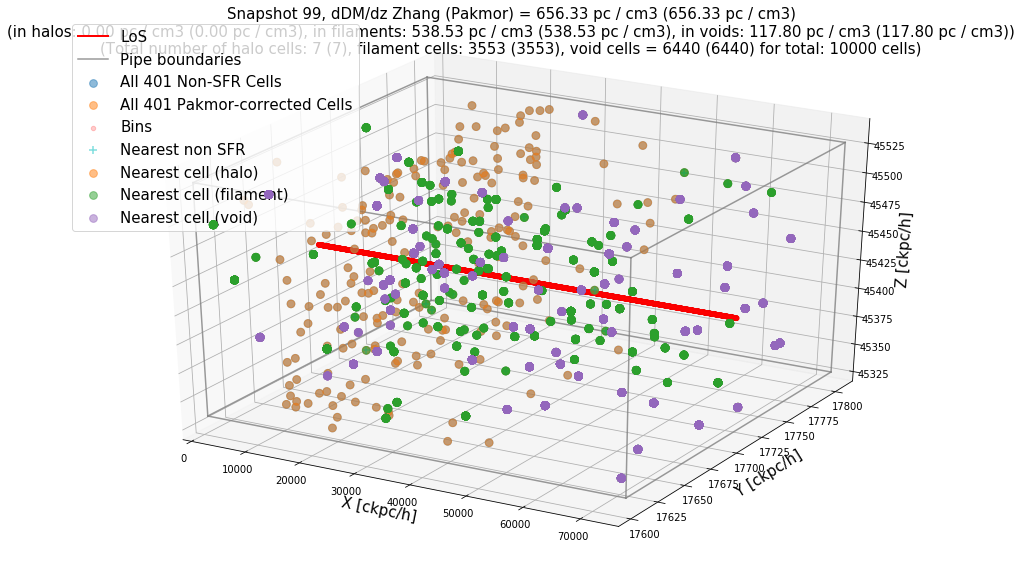

In [145]:
###################
#initialise figure#
###################

fig = plt.figure(figsize=(16,10))
ax = fig.add_subplot(111,projection='3d')
ax.set_xlim(0,header['BoxSize'])
ax.set_xlabel('X [ckpc/h]',fontsize=15)
ax.set_ylabel('Y [ckpc/h]',fontsize=15)
ax.set_zlabel('Z [ckpc/h]',fontsize=15)

#############
#Create Pipe#
#############

for i in range(npipes): #for each desired pipe
    
    pipe_number = i
    print('Creating pipe {0}'.format(pipe_number))

    #########################################
    #define los coordinates at start of pipe#
    #########################################
    
    #By Zhang+20 definition of following x-axis,
    #x will be zero, y and z will be random
    #units default = ckpc/h (compare box size to https://www.tng-project.org/about/)
    
    pipe_start_coords = np.array([0,
                         np.random.uniform(0,header['BoxSize'],1)[0],
                         np.random.uniform(0,header['BoxSize'],1)[0]])
    print('Random start cell coordinates: {0}'.format(pipe_start_coords))
    
    ###################################
    #define coordinates at end of pipe#
    ###################################
    
    #By Zhang+20 definition of following x-axis,
    #x will be length of simulation,y and z will be same as start coords
    
    pipe_end_coords = pipe_start_coords+np.array([header['BoxSize'],0,0])
    print('Pipe end cell coordinates: {0}'.format(pipe_end_coords))
    
    ########################
    #plot the line of sight#
    ########################
    
    los_toplot=list(zip(pipe_start_coords,pipe_end_coords))
    print(los_toplot)
    ax.plot(los_toplot[0],
            los_toplot[1],
            los_toplot[2],
            color='r',lw=2,label='LoS')
    
    ########################
    #construct pipe corners#
    ########################
    
    #Add and subtract half of pipe length from y and z coords for y and z boundaries
    #code adapted from https://stackoverflow.com/questions/33540109/plot-surfaces-on-a-cube
    
    c1s = pipe_start_coords + np.array([0,pipe_width/2,pipe_width/2]) #start corner 1
    c2s = pipe_start_coords + np.array([0,-pipe_width/2,-pipe_width/2]) #start corner 2
    c3s = pipe_start_coords + np.array([0,pipe_width/2,-pipe_width/2]) #start corner 3
    c4s = pipe_start_coords + np.array([0,-pipe_width/2,pipe_width/2]) #start corner 4
    
    c1e = pipe_end_coords + np.array([0,pipe_width/2,pipe_width/2]) #end corner 1
    c2e = pipe_end_coords + np.array([0,-pipe_width/2,-pipe_width/2]) #end corner 2
    c3e = pipe_end_coords + np.array([0,pipe_width/2,-pipe_width/2]) #end corner 3
    c4e = pipe_end_coords + np.array([0,-pipe_width/2,pipe_width/2]) #end corner 4
    
    corners = np.array([c1s,c2s,c3s,c4s,c1e,c2e,c3e,c4e])
    
    ######################
    #construct pipe edges#
    ######################

    line1 = list(zip(c1s,c1e))
    line2 = list(zip(c2s,c2e))
    line3 = list(zip(c3s,c3e))
    line4 = list(zip(c4s,c4e))
    line5 = list(zip(c1s,c3s))
    line6 = list(zip(c3s,c2s))
    line7 = list(zip(c2s,c4s))
    line8 = list(zip(c4s,c1s))
    line9 = list(zip(c1e,c3e))
    line10 = list(zip(c3e,c2e))
    line11 = list(zip(c2e,c4e))
    line12 = list(zip(c4e,c1e))
    
    lines_todraw = np.array([line1,line2,line3,line4,line5,line6,line7,line8,line9,line10,line11,line12])
    

    ###########
    #plot pipe#
    ###########
    
    for i in range(len(lines_todraw)):
        if i==0:
            ax.plot(lines_todraw[i][0],
                    lines_todraw[i][1],
                    lines_todraw[i][2],
                    color='gray',alpha=0.8,label='Pipe boundaries')
        else:
            ax.plot(lines_todraw[i][0],
                    lines_todraw[i][1],
                    lines_todraw[i][2],
                    color='gray',alpha=0.8)

            
    ########################
    #get cells in this pipe#
    ########################
    
    #adapted from https://stackoverflow.com/questions/42352622/finding-points-within-a-bounding-box-with-numpy
    #I think this is right but if I get any strange results, double check the theory
    
    yz_pts = dataPT0['Coordinates'][:,[1,2]] #all y and z coords
    print('All y and z values: {0}'.format(yz_pts))

    ur = c1s[1:] #upper right of pipe start (y and z only)
    ll = c2e[1:] #lower left of pipe end (y and z only)
    print('Upper right: {0}'.format(ur))
    print('Lower left: {0}'.format(ll))

    inidx = np.all((ll <= yz_pts) & (yz_pts <= ur), axis=1) #indexes of cells in pipe
    
    ###########################
    #get data of cells in pipe#
    ###########################
    
    pipe_cell_coords = dataPT0['Coordinates'][inidx]       #coordinates [ckpc/h]
    pipe_cell_dens   = dataPT0['Density'][inidx]           #densities [(1e10Msun/h)/(ckpc/h)**3]
    pipe_cell_elab   = dataPT0['ElectronAbundance'][inidx] #electron abundance [-]
    pipe_cell_sfr    = dataPT0['StarFormationRate'][inidx] #star formation rate [Msun/yr]
    pipe_cell_dark   = dataPT0['SubfindDMDensity'][inidx]  #comoving dark matter density [(1e10Msun/h)/(ckpc/h)**3]
    pipe_cell_warm   = dataPT0['Warm'][inidx]              #warm-phase gas mass fraction
    
    print('{0} cells in this pipe'.format(dataPT0['Coordinates'][inidx].shape[0]))

    ###############################
    #plot locations of these cells#
    ###############################
    
    #ax.scatter3D(pipe_cell_coords[:,0],
    #             pipe_cell_coords[:,1],
    #             pipe_cell_coords[:,2],
    #             label='Cells',s=60)
    
    
    ############################################################
    #For pure Zhang+20 method, exclude all star forming regions#
    ############################################################
    
    pipe_cell_coords_z = pipe_cell_coords[np.where(pipe_cell_sfr==0)]
    pipe_cell_dens_z = pipe_cell_dens[np.where(pipe_cell_sfr==0)]
    pipe_cell_elab_z = pipe_cell_elab[np.where(pipe_cell_sfr==0)]
    pipe_cell_sfr_z = pipe_cell_sfr[np.where(pipe_cell_sfr==0)]
    pipe_cell_dark_z = pipe_cell_dark[np.where(pipe_cell_sfr==0)]
    
    print('sum for star forming check: {0}'.format(pipe_cell_sfr_z.sum()))
    
    #############################################################################################
    #For Pakmor+18 method, apply correction to A for star forming regions and leave no cells out#
    #############################################################################################
    
    pipe_cell_coords_p = pipe_cell_coords[:]
    pipe_cell_dens_p   = pipe_cell_dens[:]
    pipe_cell_elab_p   = pipe_cell_elab[:]*pipe_cell_warm[:] #perform Pakmor correction
    pipe_cell_sfr_p    = pipe_cell_sfr[:]
    pipe_cell_dark_p   = pipe_cell_dark[:]
    print('Number of cells in Pakmor method pipe: {0}'.format(pipe_cell_dens_p.shape))
    
    ###############################
    #plot locations of these cells#
    ###############################
    
    ax.scatter3D(pipe_cell_coords_z[:,0],
                 pipe_cell_coords_z[:,1],
                 pipe_cell_coords_z[:,2],
                 label='All {0} Non-SFR Cells'.format(len(pipe_cell_coords_z)),s=60,color='C0',marker='o',alpha=0.5)
    
    ax.scatter3D(pipe_cell_coords_p[:,0],
                 pipe_cell_coords_p[:,1],
                 pipe_cell_coords_p[:,2],
                 label='All {0} Pakmor-corrected Cells'.format(len(pipe_cell_coords_p)),s=60,color='C1',marker='o',alpha=0.5)
    

    ###############################################
    #divide pipe into 10,000 bins along the x-axis#
    ###############################################
    
    #Question: why 10,000 bins given there are so few particles in the pipe?
    
    pipe_x_bins = np.linspace(pipe_start_coords[0],pipe_end_coords[0],nbins)
    print('Pipe x-axis bin coordinates: {0} ckpc/h'.format(pipe_x_bins))
    
    #######################################
    #get coordinates of center of each bin#
    #######################################
    
    pipe_bin_coords = np.array([[i,pipe_start_coords[1],pipe_start_coords[2]]for i in pipe_x_bins])
    print('Pipe x-bin_coords: {0}'.format(pipe_bin_coords))
    
    #plot locations of these bins
    ax.scatter3D(pipe_bin_coords[:,0],
             pipe_bin_coords[:,1],
             pipe_bin_coords[:,2],
             label='Bins',color='r',alpha=0.2)

    ###############################################################
    #for each bin, find distance between it and every cell in pipe#
    #find the one with miniimum distance                          #
    #this will be the cell in the los                             #
    #do for zhang (excluding sfr) and non-zhang (including sfr)   #
    ###############################################################
    
    
    ###########
    #Pakmor   #
    ###########
    
    #initialise empty array to hold indices of closest particle to each bin
    nearest_idxs_p = []
    
    for i in range(len(pipe_bin_coords)): #loop over bins
        coords = pipe_bin_coords[i] #get bin coordinates
        distarr = np.sqrt(np.sum(((pipe_cell_coords_p[:]-coords)**2),axis=1)) #create array of distances from cells
        nearest = np.argmin(distarr) #find nearest cell to bin
        nearest_idxs_p.append(nearest) #append to array
        
    nearest_idxs_p = np.array(nearest_idxs_p) #convert to numpy array
    nearest_idxs_unique_p = np.unique(nearest_idxs_p) #some cells are the closest to multiple bins. Get uniques.
    

    ##############
    #zhang method#
    ##############
    
    #initialise empty array to hold indices of closest particle to each bin
    nearest_idxs_z = []
    
    for i in range(len(pipe_bin_coords)): #loop over bins
        coords = pipe_bin_coords[i] #get bin coordinates
        distarr = np.sqrt(np.sum(((pipe_cell_coords_z[:]-coords)**2),axis=1)) #create array of distances from cells
        nearest = np.argmin(distarr) #find nearest cell to bin
        nearest_idxs_z.append(nearest) #append to array
        
    nearest_idxs_z = np.array(nearest_idxs_z) #convert to numpy array
    nearest_idxs_unique_z = np.unique(nearest_idxs_z) #some cells are the closest to multiple bins. Get uniques.
    
    print('Nearest {0} particle ids: {1}'.format(np.shape(nearest_idxs),nearest_idxs))
    print('Of these, {0} are unique: {1}'.format(np.shape(nearest_idxs_unique),nearest_idxs_unique))
    
    #################################
    #extract data from nearest cells#
    #################################
    
    ###########
    #Pakmor   #
    ###########
    
    pipe_nearest_coords_p = np.array(pipe_cell_coords_p[nearest_idxs_p]) #coordinates [ckpc/h]
    pipe_nearest_dens_p   = np.array(pipe_cell_dens_p[nearest_idxs_p])   #densities [(1e10Msun/h)/(ckpc/h)**3]
    pipe_nearest_elab_p   = np.array(pipe_cell_elab_p[nearest_idxs_p])   #electron abundance [-]
    pipe_nearest_sfr_p    = np.array(pipe_cell_sfr_p[nearest_idxs_p])    #star formation rate [Msun/yr]
    pipe_nearest_dark_p   = np.array(pipe_cell_dark_p[nearest_idxs_p])   #comooving dark matter density [(1e10Msun/h)/(ckpc/h)**3]
       
    #######
    #zhang#
    #######
    pipe_nearest_coords_z = np.array(pipe_cell_coords_z[nearest_idxs_z]) #coordinates [ckpc/h]
    pipe_nearest_dens_z   = np.array(pipe_cell_dens_z[nearest_idxs_z])   #densities [(1e10Msun/h)/(ckpc/h)**3]
    pipe_nearest_elab_z   = np.array(pipe_cell_elab_z[nearest_idxs_z])   #electron abundance [-]
    pipe_nearest_sfr_z    = np.array(pipe_cell_sfr_z[nearest_idxs_z])    #star formation rate [Msun/yr]
    pipe_nearest_dark_z   = np.array(pipe_cell_dark_z[nearest_idxs_z])   #comooving dark matter density [(1e10Msun/h)/(ckpc/h)**3]
    
    #mark locations of nearest cells to bins on plot
    #ax.scatter3D(pipe_nearest_coords[:,0],
    #         pipe_nearest_coords[:,1],
    #         pipe_nearest_coords[:,2],
    #         label='Nearest',color='k',marker='x',s=50)
    
    ax.scatter3D(pipe_nearest_coords_z[:,0],
             pipe_nearest_coords_z[:,1],
             pipe_nearest_coords_z[:,2],
             label='Nearest non SFR',color='C',marker='+',s=50,alpha=0.5)
    
    ###############################################
    #convert density to si units using artale code#
    ###############################################
    
    pipe_nearest_dens_p_si = TNG_Dens2SI_astropy(pipe_nearest_dens_p)    
    pipe_nearest_dens_z_si = TNG_Dens2SI_astropy(pipe_nearest_dens_z)
    
    ###########################################################
    #convert dark matter density to si units using artale code#
    ###########################################################
    
    pipe_nearest_dark_p_si = TNG_Dens2SI_astropy(pipe_nearest_dark_p)    
    pipe_nearest_dark_z_si = TNG_Dens2SI_astropy(pipe_nearest_dark_z) 
    
    #########################################################################
    #divide dark matter density by critical density to create the LSS tracer#
    #########################################################################
    
    pipe_nearest_LSStracer_p = pipe_nearest_dark_p_si/my_dens_crit
    pipe_nearest_LSStracer_z = pipe_nearest_dark_z_si/my_dens_crit
    print('The structure tracer array is {0}'.format(pipe_nearest_LSStracer_z))
    
    ##########################################
    #Create Large-Scale Structure (LSS) masks#
    ##########################################
    
    #non-zhang
    voi_mask_PT0_p = pipe_nearest_LSStracer_p < 0.1
    fil_mask_PT0_p = np.logical_and(pipe_nearest_LSStracer_p >= 0.1, pipe_nearest_LSStracer_p < 57)#CELESTE:CORRECTED
    hal_mask_PT0_p = pipe_nearest_LSStracer_p >= 57 
    
    #zhang
    voi_mask_PT0_z = pipe_nearest_LSStracer_z < 0.1
    fil_mask_PT0_z = np.logical_and(pipe_nearest_LSStracer_z >= 0.1, pipe_nearest_LSStracer_z < 57)#CELESTE:CORRECTED
    hal_mask_PT0_z = pipe_nearest_LSStracer_z >= 57 
    
    
    ##############################################################
    #Calculate the number of nearest cells of each structure type#
    ##############################################################
    
    num_voi_cells_z = np.shape(pipe_nearest_coords_z[voi_mask_PT0])[0]
    num_fil_cells_z = np.shape(pipe_nearest_coords_z[fil_mask_PT0])[0]
    num_hal_cells_z = np.shape(pipe_nearest_coords_z[hal_mask_PT0])[0]
    
    num_voi_cells_p = np.shape(pipe_nearest_coords_p[voi_mask_PT0])[0]
    num_fil_cells_p = np.shape(pipe_nearest_coords_p[fil_mask_PT0])[0]
    num_hal_cells_p = np.shape(pipe_nearest_coords_p[hal_mask_PT0])[0]
    
    #################################################
    #plot each structure type as a separate colour#
    #################################################
    
    #halos
    ax.scatter3D(pipe_nearest_coords_z[hal_mask_PT0_z][:,0],
             pipe_nearest_coords_z[hal_mask_PT0_z][:,1],
             pipe_nearest_coords_z[hal_mask_PT0_z][:,2],
             label='Nearest cell (halo)',color='C1',marker='o',s=60,alpha=0.5)

    #filaments
    ax.scatter3D(pipe_nearest_coords_z[fil_mask_PT0_z][:,0],
             pipe_nearest_coords_z[fil_mask_PT0_z][:,1],
             pipe_nearest_coords_z[fil_mask_PT0_z][:,2],
             label='Nearest cell (filament)',color='C2',marker='o',s=60,alpha=0.5)
    
    #voids
    ax.scatter3D(pipe_nearest_coords_z[voi_mask_PT0_z][:,0],
             pipe_nearest_coords_z[voi_mask_PT0_z][:,1],
             pipe_nearest_coords_z[voi_mask_PT0_z][:,2],
             label='Nearest cell (void)',color='C4',marker='o',s=60,alpha=0.5)
    
    ##########################################
    #get electron density at each of the bins#
    ##########################################
    
    #follow zhang+20 equation exactly as native units of TNG are
    #comoving
    
    #############################################################
    #Zhang: pne = (ElAb)*hmasssfrac*(Dens/protonmass)*((1+z)**3)#
    #use data which excludes SFRs                               #
    #############################################################
    
    #total
    pipe_nearest_pne_z = (pipe_nearest_elab_z)*hmassfrac*(pipe_nearest_dens_z_si/protonmass)*((1+header['Redshift'])**3)
    pipe_nearest_pne_p = (pipe_nearest_elab_p)*hmassfrac*(pipe_nearest_dens_p_si/protonmass)*((1+header['Redshift'])**3)
    print('pnes for Zhang (Pakmor) method are: {0} ({1})'.format(pipe_nearest_pne_z,pipe_nearest_pne_p))
    
    #halos
    pipe_nearest_pne_z_hal = (pipe_nearest_elab_z[hal_mask_PT0_z])*hmassfrac*(pipe_nearest_dens_z_si[hal_mask_PT0_z]/protonmass)*((1+header['Redshift'])**3)
    pipe_nearest_pne_p_hal = (pipe_nearest_elab_p[hal_mask_PT0_p])*hmassfrac*(pipe_nearest_dens_p_si[hal_mask_PT0_p]/protonmass)*((1+header['Redshift'])**3)
    print('pnes for Zhang (Pakmor) method in halos are: {0} ({1})'.format(pipe_nearest_pne_z_hal,pipe_nearest_pne_p_hal))
    
    #filaments
    pipe_nearest_pne_z_fil = (pipe_nearest_elab_z[fil_mask_PT0_z])*hmassfrac*(pipe_nearest_dens_z_si[fil_mask_PT0_z]/protonmass)*((1+header['Redshift'])**3)
    pipe_nearest_pne_p_fil = (pipe_nearest_elab_p[fil_mask_PT0_p])*hmassfrac*(pipe_nearest_dens_p_si[fil_mask_PT0_p]/protonmass)*((1+header['Redshift'])**3)
    print('pnes for Zhang (Pakmor) method in filaments are: {0} ({1})'.format(pipe_nearest_pne_z_fil,pipe_nearest_pne_p_fil))
    
    #voids
    pipe_nearest_pne_z_voi = (pipe_nearest_elab_z[voi_mask_PT0_z])*hmassfrac*(pipe_nearest_dens_z_si[voi_mask_PT0_z]/protonmass)*((1+header['Redshift'])**3)
    pipe_nearest_pne_p_voi = (pipe_nearest_elab_p[voi_mask_PT0_p])*hmassfrac*(pipe_nearest_dens_p_si[voi_mask_PT0_p]/protonmass)*((1+header['Redshift'])**3)
    print('pnes for Zhang (Pakmor) method in voids are: {0} ({1})'.format(pipe_nearest_pne_z_voi,pipe_nearest_pne_p_voi))
    
    
    ######################################################################
    #Non-zhang: pne = (ElAb*Warm)*hmasssfrac*(Dens/protonmass)*((1+z)**3)#
    #use all data (sfr included) and warm mass fraction                  #
    ######################################################################    
    
    ##################################
    #average these electron densities#
    ##################################
    
    #Zhang method
    
    #total
    pipe_average_pne_z = np.mean(pipe_nearest_pne_z)
    pipe_average_pne_p = np.mean(pipe_nearest_pne_p)
    print('Average pne for Zhang (Pakmor) method is: {0} ({1})'.format(pipe_average_pne_z,pipe_average_pne_p))
    
    #halos
    pipe_average_pne_z_hal = np.sum(pipe_nearest_pne_z_hal)/nbins
    pipe_average_pne_p_hal = np.sum(pipe_nearest_pne_p_hal)/nbins
    print('Average pne for Zhang (Pakmor) method in halos is: {0} ({1})'.format(pipe_average_pne_z_hal,pipe_average_pne_p_hal))
    
    #filaments
    pipe_average_pne_z_fil = np.sum(pipe_nearest_pne_z_fil)/nbins
    pipe_average_pne_p_fil = np.sum(pipe_nearest_pne_p_fil)/nbins
    print('Average pne for Zhang (Pakmor) method in filaments is: {0} ({1})'.format(pipe_average_pne_z_fil,pipe_average_pne_p_fil))
    
    #voids
    pipe_average_pne_z_voi = np.sum(pipe_nearest_pne_z_voi)/nbins
    pipe_average_pne_p_voi = np.sum(pipe_nearest_pne_p_voi)/nbins
    print('Average pne for Zhang (Pakmor) method in voids is: {0} ({1})'.format(pipe_average_pne_z_voi,pipe_average_pne_p_voi))
    
    ################################
    #calculate dDM/dz for this pipe#
    ################################
    
    #outer bit of eq 7
    outer=c.c/cosmosource.H(0)
    print(outer)

    #E(z) according to paper eq 5
    Ez = np.sqrt((0.3089*((1+header['Redshift'])**(3)))+(0.6911))
    print(Ez)
    
    #denominator of eq 7
    denominator = ((1+header['Redshift'])**(2))*Ez

    #remainder of equation 7
    
    #total
    edens_z = pipe_average_pne_z
    ddmdz_z = outer*edens_z/denominator
    edens_p = pipe_average_pne_p
    ddmdz_p = outer*edens_p/denominator
    
    #halos
    edens_z_hal = pipe_average_pne_z_hal
    ddmdz_z_hal = outer*edens_z_hal/denominator
    edens_p_hal = pipe_average_pne_p_hal
    ddmdz_p_hal = outer*edens_p_hal/denominator
    
    #filaments
    edens_z_fil = pipe_average_pne_z_fil
    ddmdz_z_fil = outer*edens_z_fil/denominator
    edens_p_fil = pipe_average_pne_p_fil
    ddmdz_p_fil = outer*edens_p_fil/denominator
    
    #voids
    edens_z_voi = pipe_average_pne_z_voi
    ddmdz_z_voi = outer*edens_z_voi/denominator
    edens_p_voi = pipe_average_pne_p_voi
    ddmdz_p_voi = outer*edens_p_voi/denominator
    
    print('dDM/dz Zhang (Pakmor) = {0} ({1})'.format(ddmdz_z.to('pc*cm**(-3)'),ddmdz_p.to('pc*cm**(-3)')))
    print('dDM/dz Zhang (Pakmor) in halos = {0} ({1})'.format(ddmdz_z_hal.to('pc*cm**(-3)'),ddmdz_p_hal.to('pc*cm**(-3)')))
    print('dDM/dz Zhang (Pakmor) in filaments = {0} ({1})'.format(ddmdz_z_fil.to('pc*cm**(-3)'),ddmdz_p_fil.to('pc*cm**(-3)')))
    print('dDM/dz Zhang (Pakmor) in voids = {0} ({1})'.format(ddmdz_z_voi.to('pc*cm**(-3)'),ddmdz_p_voi.to('pc*cm**(-3)')))
        
    ax.set_title('Snapshot {0}, dDM/dz Zhang (Pakmor) = {1:.2f} ({2:.2f})\n(in halos: {3:.2f} ({4:.2f}), in filaments: {5:.2f} ({6:.2f}), in voids: {7:.2f} ({8:.2f}))\n(Total number of halo cells: {9} ({10}), filament cells: {11} ({12}), void cells = {13} ({14}) for total: {15} cells)'.format(snap_number,
    ddmdz_z.to('pc*cm**(-3)'),ddmdz_p.to('pc*cm**(-3)'),
    ddmdz_z_hal.to('pc*cm**(-3)'),ddmdz_p_hal.to('pc*cm**(-3)'),
    ddmdz_z_fil.to('pc*cm**(-3)'),ddmdz_p_fil.to('pc*cm**(-3)'),
    ddmdz_z_voi.to('pc*cm**(-3)'),ddmdz_p_voi.to('pc*cm**(-3)'),
    num_hal_cells_z,num_hal_cells_p,
    num_fil_cells_z,num_fil_cells_p,
    num_voi_cells_z,num_voi_cells_p,
    num_hal_cells_z+num_fil_cells_z+num_voi_cells_z),fontsize=15)

    
    
plt.legend(fontsize=15)

# create multiple of these for each snapshot and store

In [153]:

############
#initialise#
############

sim_to_use = 'TNG100-3'
print('Simulation to use will be: {0}'.format(sim_to_use))

pipes_per_snap = 5125
print('Number of pipes to create per snapshot: {0}'.format(pipes_per_snap))

snaps_to_process = [99,91,84,78,72,67,59,50,40,33,25,21,17]#,13,11,8,6,4,3,2]
print('Snapshots to process will be {0}'.format(snaps_to_process))

#The number of cells in the chosen snapshot
ncells = dataPT0['Coordinates'].shape[0]
print('Number of cells in snapshot {0} is {1}'.format(snap_number,ncells))

#The width of the pipe
pipe_width = 200 #By following zhang+20 definition, sides will be 200ckpc/h in length
print('Pipe width will be {0} ckpc/h'.format(pipe_width))

#The number of bins along a single line of sight
nbins=10000 #Zhang+20 definition: 10,000
print('There will be {0} bins on each sightline'.format(nbins))

#Define the mass of a proton for dDM/dz calculations
protonmass = c.m_p.to('kg')
print('Proton mass is {0}'.format(protonmass))

#Define the hydrogen mass fraction for dDM/dz calculations
hmassfrac = 3./4.
print('Chosen H mass fraction is {0}. Check whether this is correct'.format(hmassfrac))

#calculate the critical density at redshift zero for structure categorisation
#source to formula: https://astronomy.swin.edu.au/cosmos/c/Critical+Density
grav=c.G.to('m**3/(kg*s**2)') #g as a YT quantity in correct units
H=cosmosource.H(0).to('km/s/Mpc') #hubble const at z=0 in km/s/Mpc
my_dens_crit = ((3 * H**2)/(8*np.pi* grav)).to('kg/m**3')
print('Critical density at z=0 = {0}'.format(my_dens_crit))





Simulation to use will be: TNG100-3
Number of pipes to create per snapshot: 5125
Snapshots to process will be [99, 91, 84, 78, 72, 67, 59, 50, 40, 33, 25, 21, 17]
Number of cells in snapshot 17 is 93761227
Pipe width will be 200 ckpc/h
There will be 10000 bins on each sightline
Proton mass is 1.67262192369e-27 kg
Chosen H mass fraction is 0.75. Check whether this is correct
Critical density at z=0 = 8.619160453152573e-27 kg / m3


In [ ]:
#####################
#Loop over snapshots#
#####################

for snapshot_to_process in range(len(snaps_to_process)):
   
    ############
    #initialise#
    ############
    
    npipes            = pipes_per_snap  #number of pipes to create
    snap_number       = snaps_to_process[snapshot_to_process] #snapshot number for test
    
    dDMdz_z_output      = [] #array to hold total dDMdz values (Zhang)
    dDMdz_p_output      = [] #array to hold total dDMdz values (Pakmor)
    
    dDMdz_Hal_z_output  = [] #array to hold total dDMdz from halos (Zhang)
    dDMdz_Hal_p_output  = [] #array to hold total dDMdz from halos (Pakmor)
    
    dDMdz_Fil_z_output  = [] #array to hold total dDMdz from filaments (Zhang)
    dDMdz_Fil_p_output  = [] #array to hold total dDMdz from filaments (Pakmor)

    dDMdz_Voi_z_output  = [] #array to hold total dDMdz from voids (Zhang)  
    dDMdz_Voi_p_output  = [] #array to hold total dDMdz from voids (Pakmor)  

    num_h_cell_z_output = [] #array to hold number of cells in halos used to get dDM/dz (Zhang)
    num_h_cell_p_output = [] #array to hold number of cells in halos used to get dDM/dz (Pakmor)

    num_f_cell_z_output = [] #array to hold number of cells in filaments used to get dDM/dz (Zhang)
    num_f_cell_p_output = [] #array to hold number of cells in filaments used to get dDM/dz (Pakmor)

    num_v_cell_z_output = [] #array to hold number of cells in voids used to get dDM/dz (Zhang)
    num_v_cell_p_output = [] #array to hold number of cells in voids used to get dDM/dz (Pakmor)

    snap_results_dict = {} #dictionary to hold all results
    
    print('Currently processing snapshot: {0}'.format(snap_number))

    ###########
    #load data#
    ###########
    
    #basePath = '/ptmp/cwalker/Illustris_FRB_Project/TNG_copies/virgo/simulations/IllustrisTNG/{0}/output/'.format(sim_to_use)
    basePath = '/virgo/simulations/IllustrisTNG/{0}/output/'.format(sim_to_use)

    dataPT0 = il.snapshot.loadSubset(basePath, snap_number, 'gas', fields=['Density',
                                                                           'ElectronAbundance',
                                                                           'StarFormationRate',
                                                                           'Coordinates',
                                                                           'Masses',
                                                                           'InternalEnergy',
                                                                           'SubfindDMDensity'])
    ncells = dataPT0['Coordinates'].shape[0]
    print('Number of cells in snapshot {0} is {1}'.format(snap_number,ncells))
    
    ######################################
    #create warm-phase gas mass fractions#
    ######################################
    #note: this is from _w_frac_new() function in 
    #raven:/u/cwalker/Illustris_FRB_Project/oct2_2021_output/IGM_new_scripts/job_raven.py

    density = dataPT0['Density'] #the density values along the light ray in gcm**-3
    sfr     = dataPT0['StarFormationRate'] #the star formation rate along the light ray in g/s
    ie      = dataPT0['InternalEnergy'] #the internal energy along the light ray in erg/g
    ea      = dataPT0['ElectronAbundance'] #the electron abundance along the light ray

    #define constants
    T_h = 10**7  #hot phase gase temperature [Kelvin] 
    T_c = 10**3  #cold phase gas temperature [Kelvin]
    x_h = 0.75   #Hydrogen mass fraction


    #calculate x and w, cold and warm phase gas mass fractions
    x_frac = (temp2u(T_h,ea)-ie)/(temp2u(T_h,ea)-temp2u(T_c,ea)) #cold phase mass fraction
    w_frac = 1 - x_frac # warm phase mass fraction

    #only modify electron abundance if sfr = 0
    w_frac[np.where(sfr==0)]=1

    #append to the data dictionary
    dataPT0['Warm'] = w_frac
    
    #############
    #load header#
    #############
    
    header = il.groupcat.loadHeader(basePath,snap_number)
    print('Header for snap = {0}'.format(header))
    
    ###########################
    ###########################
    ##create pipes, get dDMdz##
    ###########################
    ###########################

    for i in range(npipes): #for each desired pipe

        
        #############
        #Create Pipe#
        #############
        
        pipe_number = i
        #print('Creating pipe {0}'.format(pipe_number))


        #########################################
        #define los coordinates at start of pipe#
        #########################################

        #By Zhang+20 definition of following x-axis,
        #x will be zero, y and z will be random
        #units default = ckpc/h (compare box size to https://www.tng-project.org/about/)

        pipe_start_coords = np.array([0,
                             np.random.uniform(0,header['BoxSize'],1)[0],
                             np.random.uniform(0,header['BoxSize'],1)[0]])
        #print('Random start cell coordinates: {0}'.format(pipe_start_coords))

        ###################################
        #define coordinates at end of pipe#
        ###################################

        #By Zhang+20 definition of following x-axis,
        #x will be length of simulation,y and z will be same as start coords

        pipe_end_coords = pipe_start_coords+np.array([header['BoxSize'],0,0])
        #print('Pipe end cell coordinates: {0}'.format(pipe_end_coords))

        
        ########################
        #plot the line of sight#
        ########################

        los_toplot=list(zip(pipe_start_coords,pipe_end_coords))
        #print(los_toplot)
        #ax.plot(los_toplot[0],
        #        los_toplot[1],
        #        los_toplot[2],
        #        color='r',lw=2,label='LoS')
    
        ########################
        #construct pipe corners#
        ########################

        #Add and subtract half of pipe length from y and z coords for y and z boundaries
        #code adapted from https://stackoverflow.com/questions/33540109/plot-surfaces-on-a-cube

        c1s = pipe_start_coords + np.array([0,pipe_width/2,pipe_width/2]) #start corner 1
        c2s = pipe_start_coords + np.array([0,-pipe_width/2,-pipe_width/2]) #start corner 2
        c3s = pipe_start_coords + np.array([0,pipe_width/2,-pipe_width/2]) #start corner 3
        c4s = pipe_start_coords + np.array([0,-pipe_width/2,pipe_width/2]) #start corner 4

        c1e = pipe_end_coords + np.array([0,pipe_width/2,pipe_width/2]) #end corner 1
        c2e = pipe_end_coords + np.array([0,-pipe_width/2,-pipe_width/2]) #end corner 2
        c3e = pipe_end_coords + np.array([0,pipe_width/2,-pipe_width/2]) #end corner 3
        c4e = pipe_end_coords + np.array([0,-pipe_width/2,pipe_width/2]) #end corner 4

        corners = np.array([c1s,c2s,c3s,c4s,c1e,c2e,c3e,c4e])
    
        ######################
        #construct pipe edges#
        ######################

        line1 = list(zip(c1s,c1e))
        line2 = list(zip(c2s,c2e))
        line3 = list(zip(c3s,c3e))
        line4 = list(zip(c4s,c4e))
        line5 = list(zip(c1s,c3s))
        line6 = list(zip(c3s,c2s))
        line7 = list(zip(c2s,c4s))
        line8 = list(zip(c4s,c1s))
        line9 = list(zip(c1e,c3e))
        line10 = list(zip(c3e,c2e))
        line11 = list(zip(c2e,c4e))
        line12 = list(zip(c4e,c1e))
    
        lines_todraw = np.array([line1,line2,line3,line4,line5,line6,line7,line8,line9,line10,line11,line12])
    

        ###########
        #plot pipe#
        ###########

        #for i in range(len(lines_todraw)):
        #    if i==0:
        #        ax.plot(lines_todraw[i][0],
        #                lines_todraw[i][1],
        #                lines_todraw[i][2],
        #                color='gray',alpha=0.8,label='Pipe boundaries')
        #    else:
        #        ax.plot(lines_todraw[i][0],
        #                lines_todraw[i][1],
        #                lines_todraw[i][2],
        #                color='gray',alpha=0.8)        

        ########################
        #get cells in this pipe#
        ########################

        #adapted from https://stackoverflow.com/questions/42352622/finding-points-within-a-bounding-box-with-numpy
        #I think this is right but if I get any strange results, double check the theory

        yz_pts = dataPT0['Coordinates'][:,[1,2]] #all y and z coords
        #print('All y and z values: {0}'.format(yz_pts))

        ur = c1s[1:] #upper right of pipe start (y and z only)
        ll = c2e[1:] #lower left of pipe end (y and z only)
        #print('Upper right: {0}'.format(ur))
        #print('Lower left: {0}'.format(ll))

        inidx = np.all((ll <= yz_pts) & (yz_pts <= ur), axis=1) #indexes of cells in pipe
    

        ###########################
        #get data of cells in pipe#
        ###########################

        pipe_cell_coords = dataPT0['Coordinates'][inidx]       #coordinates [ckpc/h]
        pipe_cell_dens   = dataPT0['Density'][inidx]           #densities [(1e10Msun/h)/(ckpc/h)**3]
        pipe_cell_elab   = dataPT0['ElectronAbundance'][inidx] #electron abundance [-]
        pipe_cell_sfr    = dataPT0['StarFormationRate'][inidx] #star formation rate [Msun/yr]
        pipe_cell_dark   = dataPT0['SubfindDMDensity'][inidx]  #comoving dark matter density [(1e10Msun/h)/(ckpc/h)**3]
        pipe_cell_warm   = dataPT0['Warm'][inidx]              #warm-phase gas mass fraction

        #print('{0} cells in this pipe'.format(dataPT0['Coordinates'][inidx].shape[0]))
    
        ###############################
        #plot locations of these cells#
        ###############################

        #ax.scatter3D(pipe_cell_coords[:,0],
        #             pipe_cell_coords[:,1],
        #             pipe_cell_coords[:,2],
        #             label='Cells',s=60)


        ############################################################
        #For pure Zhang+20 method, exclude all star forming regions#
        ############################################################

        pipe_cell_coords_z = pipe_cell_coords[np.where(pipe_cell_sfr==0)]
        pipe_cell_dens_z = pipe_cell_dens[np.where(pipe_cell_sfr==0)]
        pipe_cell_elab_z = pipe_cell_elab[np.where(pipe_cell_sfr==0)]
        pipe_cell_sfr_z = pipe_cell_sfr[np.where(pipe_cell_sfr==0)]
        pipe_cell_dark_z = pipe_cell_dark[np.where(pipe_cell_sfr==0)]

        #print('sum for star forming check: {0}'.format(pipe_cell_sfr_z.sum()))
        
        #############################################################################################
        #For Pakmor+18 method, apply correction to A for star forming regions and leave no cells out#
        #############################################################################################

        pipe_cell_coords_p = pipe_cell_coords[:]
        pipe_cell_dens_p   = pipe_cell_dens[:]
        pipe_cell_elab_p   = pipe_cell_elab[:]*pipe_cell_warm[:] #perform Pakmor correction
        pipe_cell_sfr_p    = pipe_cell_sfr[:]
        pipe_cell_dark_p   = pipe_cell_dark[:]
        
        #print('Number of cells in Pakmor method pipe: {0}'.format(pipe_cell_dens_p.shape))

        ###############################
        #plot locations of these cells#
        ###############################

        #ax.scatter3D(pipe_cell_coords_z[:,0],
        #             pipe_cell_coords_z[:,1],
        #             pipe_cell_coords_z[:,2],
        #             label='All Non-SFR Cells',s=60,color='C0',marker='o')

        ###############################################
        #divide pipe into 10,000 bins along the x-axis#
        ###############################################

        #Question: why 10,000 bins given there are so few particles in the pipe?

        pipe_x_bins = np.linspace(pipe_start_coords[0],pipe_end_coords[0],nbins)
        #print('Pipe x-axis bin coordinates: {0} ckpc/h'.format(pipe_x_bins))

        #######################################
        #get coordinates of center of each bin#
        #######################################

        pipe_bin_coords = np.array([[i,pipe_start_coords[1],pipe_start_coords[2]]for i in pipe_x_bins])
        #print('Pipe x-bin_coords: {0}'.format(pipe_bin_coords))

        #plot locations of these bins
        #ax.scatter3D(pipe_bin_coords[:,0],
        #         pipe_bin_coords[:,1],
        #         pipe_bin_coords[:,2],
        #         label='Bins',color='r',alpha=0.2)        

        
        ###############################################################
        #for each bin, find distance between it and every cell in pipe#
        #find the one with miniimum distance                          #
        #this will be the cell in the los                             #
        #do for zhang (excluding sfr) and non-zhang (including sfr)   #
        ###############################################################


        ###########
        #Pakmor   #
        ###########

        #initialise empty array to hold indices of closest particle to each bin
        nearest_idxs_p = []

        for i in range(len(pipe_bin_coords)): #loop over bins
            coords = pipe_bin_coords[i] #get bin coordinates
            distarr = np.sqrt(np.sum(((pipe_cell_coords_p[:]-coords)**2),axis=1)) #create array of distances from cells
            nearest = np.argmin(distarr) #find nearest cell to bin
            nearest_idxs_p.append(nearest) #append to array

        nearest_idxs_p = np.array(nearest_idxs_p) #convert to numpy array
        nearest_idxs_unique_p = np.unique(nearest_idxs_p) #some cells are the closest to multiple bins. Get uniques.

        ##############
        #zhang method#
        ##############

        #initialise empty array to hold indices of closest particle to each bin
        nearest_idxs_z = []

        for i in range(len(pipe_bin_coords)): #loop over bins
            coords = pipe_bin_coords[i] #get bin coordinates
            distarr = np.sqrt(np.sum(((pipe_cell_coords_z[:]-coords)**2),axis=1)) #create array of distances from cells
            nearest = np.argmin(distarr) #find nearest cell to bin
            nearest_idxs_z.append(nearest) #append to array

        nearest_idxs_z = np.array(nearest_idxs_z) #convert to numpy array
        nearest_idxs_unique_z = np.unique(nearest_idxs_z) #some cells are the closest to multiple bins. Get uniques.

        #print('Nearest {0} particle ids: {1}'.format(np.shape(nearest_idxs),nearest_idxs))
        #print('Of these, {0} are unique: {1}'.format(np.shape(nearest_idxs_unique),nearest_idxs_unique))
    
        #################################
        #extract data from nearest cells#
        #################################

        ###########
        #Pakmor   #
        ###########

        pipe_nearest_coords_p = np.array(pipe_cell_coords_p[nearest_idxs_p]) #coordinates [ckpc/h]
        pipe_nearest_dens_p   = np.array(pipe_cell_dens_p[nearest_idxs_p])   #densities [(1e10Msun/h)/(ckpc/h)**3]
        pipe_nearest_elab_p   = np.array(pipe_cell_elab_p[nearest_idxs_p])   #electron abundance [-]
        pipe_nearest_sfr_p    = np.array(pipe_cell_sfr_p[nearest_idxs_p])    #star formation rate [Msun/yr]
        pipe_nearest_dark_p   = np.array(pipe_cell_dark_p[nearest_idxs_p])   #comooving dark matter density [(1e10Msun/h)/(ckpc/h)**3]

        #######
        #zhang#
        #######
        pipe_nearest_coords_z = np.array(pipe_cell_coords_z[nearest_idxs_z]) #coordinates [ckpc/h]
        pipe_nearest_dens_z   = np.array(pipe_cell_dens_z[nearest_idxs_z])   #densities [(1e10Msun/h)/(ckpc/h)**3]
        pipe_nearest_elab_z   = np.array(pipe_cell_elab_z[nearest_idxs_z])   #electron abundance [-]
        pipe_nearest_sfr_z    = np.array(pipe_cell_sfr_z[nearest_idxs_z])    #star formation rate [Msun/yr]
        pipe_nearest_dark_z   = np.array(pipe_cell_dark_z[nearest_idxs_z])   #comooving dark matter density [(1e10Msun/h)/(ckpc/h)**3]

        #mark locations of nearest cells to bins on plot
        #ax.scatter3D(pipe_nearest_coords[:,0],
        #         pipe_nearest_coords[:,1],
        #         pipe_nearest_coords[:,2],
        #         label='Nearest',color='k',marker='x',s=50)

        #ax.scatter3D(pipe_nearest_coords_z[:,0],
        #         pipe_nearest_coords_z[:,1],
        #         pipe_nearest_coords_z[:,2],
        #         label='Nearest non SFR',color='C',marker='+',s=50,alpha=0.5)        
        
        ###############################################
        #convert density to si units using artale code#
        ###############################################

        pipe_nearest_dens_p_si = TNG_Dens2SI_astropy(pipe_nearest_dens_p)
        pipe_nearest_dens_z_si = TNG_Dens2SI_astropy(pipe_nearest_dens_z)

        ###########################################################
        #convert dark matter density to si units using artale code#
        ###########################################################

        pipe_nearest_dark_p_si = TNG_Dens2SI_astropy(pipe_nearest_dark_p)         
        pipe_nearest_dark_z_si = TNG_Dens2SI_astropy(pipe_nearest_dark_z)         
        
        #########################################################################
        #divide dark matter density by critical density to create the LSS tracer#
        #########################################################################

        pipe_nearest_LSStracer_p = pipe_nearest_dark_p_si/my_dens_crit
        pipe_nearest_LSStracer_z = pipe_nearest_dark_z_si/my_dens_crit
        #print('The structure tracer array is {0}'.format(pipe_nearest_LSStracer_z))        
        
        ##########################################
        #Create Large-Scale Structure (LSS) masks#
        ##########################################

        #non-zhang
        voi_mask_PT0_p = pipe_nearest_LSStracer_p < 0.1
        fil_mask_PT0_p = np.logical_and(pipe_nearest_LSStracer_p >= 0.1, pipe_nearest_LSStracer_p < 57)#CELESTE:CORRECTED
        hal_mask_PT0_p = pipe_nearest_LSStracer_p >= 57 

        #zhang
        voi_mask_PT0_z = pipe_nearest_LSStracer_z < 0.1
        fil_mask_PT0_z = np.logical_and(pipe_nearest_LSStracer_z >= 0.1, pipe_nearest_LSStracer_z < 57)#CELESTE:CORRECTED
        hal_mask_PT0_z = pipe_nearest_LSStracer_z >= 57         

        ##############################################################
        #Calculate the number of nearest cells of each structure type#
        ##############################################################
        
        

        num_voi_cells_z = np.shape(pipe_nearest_coords_z[voi_mask_PT0_z])[0]
        num_fil_cells_z = np.shape(pipe_nearest_coords_z[fil_mask_PT0_z])[0]
        num_hal_cells_z = np.shape(pipe_nearest_coords_z[hal_mask_PT0_z])[0]
        
        num_voi_cells_p = np.shape(pipe_nearest_coords_p[voi_mask_PT0_p])[0]
        num_fil_cells_p = np.shape(pipe_nearest_coords_p[fil_mask_PT0_p])[0]
        num_hal_cells_p = np.shape(pipe_nearest_coords_p[hal_mask_PT0_p])[0]
        
        #print('number of filament cells according to mask',num_fil_cells_p)


        #################################################
        #plot each structure type as a separate colour#
        #################################################

        #halos
        #ax.scatter3D(pipe_nearest_coords_z[hal_mask_PT0_z][:,0],
        #         pipe_nearest_coords_z[hal_mask_PT0_z][:,1],
        #         pipe_nearest_coords_z[hal_mask_PT0_z][:,2],
        #         label='Nearest cell (halo)',color='C1',marker='o',s=60,alpha=0.5)

        #filaments
        #ax.scatter3D(pipe_nearest_coords_z[fil_mask_PT0_z][:,0],
        #         pipe_nearest_coords_z[fil_mask_PT0_z][:,1],
        #         pipe_nearest_coords_z[fil_mask_PT0_z][:,2],
        #         label='Nearest cell (filament)',color='C2',marker='o',s=60,alpha=0.5)

        #voids
        #ax.scatter3D(pipe_nearest_coords_z[voi_mask_PT0_z][:,0],
        #         pipe_nearest_coords_z[voi_mask_PT0_z][:,1],
        #         pipe_nearest_coords_z[voi_mask_PT0_z][:,2],
        #         label='Nearest cell (void)',color='C4',marker='o',s=60,alpha=0.5)

        ##########################################
        #get electron density at each of the bins#
        ##########################################

        #follow zhang+20 equation exactly as native units of TNG are
        #comoving

        #############################################################
        #Zhang: pne = (ElAb)*hmasssfrac*(Dens/protonmass)*((1+z)**3)#
        #use data which excludes SFRs                               #
        #############################################################

        #total
        pipe_nearest_pne_z = (pipe_nearest_elab_z)*hmassfrac*(pipe_nearest_dens_z_si/protonmass)*((1+header['Redshift'])**3)
        pipe_nearest_pne_p = (pipe_nearest_elab_p)*hmassfrac*(pipe_nearest_dens_p_si/protonmass)*((1+header['Redshift'])**3)
        #print('pnes are: {0}'.format(pipe_nearest_pne_z))
        
        #halos
        pipe_nearest_pne_z_hal = (pipe_nearest_elab_z[hal_mask_PT0_z])*hmassfrac*(pipe_nearest_dens_z_si[hal_mask_PT0_z]/protonmass)*((1+header['Redshift'])**3)
        pipe_nearest_pne_p_hal = (pipe_nearest_elab_z[hal_mask_PT0_p])*hmassfrac*(pipe_nearest_dens_p_si[hal_mask_PT0_p]/protonmass)*((1+header['Redshift'])**3)
        #print('pnes in halos are: {0}'.format(pipe_nearest_pne_z_hal))

        #filaments
        pipe_nearest_pne_z_fil = (pipe_nearest_elab_z[fil_mask_PT0_z])*hmassfrac*(pipe_nearest_dens_z_si[fil_mask_PT0_z]/protonmass)*((1+header['Redshift'])**3)
        pipe_nearest_pne_p_fil = (pipe_nearest_elab_p[fil_mask_PT0_p])*hmassfrac*(pipe_nearest_dens_p_si[fil_mask_PT0_p]/protonmass)*((1+header['Redshift'])**3)
        #print('pnes in filaments are: {0}'.format(pipe_nearest_pne_z_fil))

        #voids
        pipe_nearest_pne_z_voi = (pipe_nearest_elab_z[voi_mask_PT0_z])*hmassfrac*(pipe_nearest_dens_z_si[voi_mask_PT0_z]/protonmass)*((1+header['Redshift'])**3)
        pipe_nearest_pne_p_voi = (pipe_nearest_elab_z[voi_mask_PT0_p])*hmassfrac*(pipe_nearest_dens_p_si[voi_mask_PT0_p]/protonmass)*((1+header['Redshift'])**3)
        #print('pnes in voids are: {0}'.format(pipe_nearest_pne_z_voi))
    

        ######################################################################
        #Non-zhang: pne = (ElAb*Warm)*hmasssfrac*(Dens/protonmass)*((1+z)**3)#
        #use all data (sfr included) and warm mass fraction                  #
        ######################################################################    

        ##################################
        #average these electron densities#
        ##################################

        #Zhang method/Pakmor method

        #total
        pipe_average_pne_z = np.mean(pipe_nearest_pne_z)
        pipe_average_pne_p = np.mean(pipe_nearest_pne_p)
        #print('Average pne is: {0}'.format(pipe_average_pne_z))   

        #halos
        pipe_average_pne_z_hal = np.sum(pipe_nearest_pne_z_hal)/nbins
        pipe_average_pne_p_hal = np.sum(pipe_nearest_pne_p_hal)/nbins
        #print('Average pne in halos is: {0}'.format(pipe_average_pne_z_hal))

        #filaments
        pipe_average_pne_z_fil = np.sum(pipe_nearest_pne_z_fil)/nbins
        pipe_average_pne_p_fil = np.sum(pipe_nearest_pne_p_fil)/nbins
        #print('Average pne in filaments is: {0}'.format(pipe_average_pne_z_fil))

        #voids
        pipe_average_pne_z_voi = np.sum(pipe_nearest_pne_z_voi)/nbins
        pipe_average_pne_p_voi = np.sum(pipe_nearest_pne_p_voi)/nbins
        #print('Average pne in voids is: {0}'.format(pipe_average_pne_z_voi))

        
        ################################
        #calculate dDM/dz for this pipe#
        ################################

        #outer bit of eq 7
        outer=c.c/cosmosource.H(0)
        #print(outer)

        #E(z) according to paper eq 5
        Ez = np.sqrt((0.3089*((1+header['Redshift'])**(3)))+(0.6911))
        #print(Ez)

        #denominator of eq 7
        denominator = ((1+header['Redshift'])**(2))*Ez

        #remainder of equation 7

        #total
        edens_z = pipe_average_pne_z
        ddmdz_z = outer*edens_z/denominator
        edens_p = pipe_average_pne_p
        ddmdz_p = outer*edens_p/denominator
        #print('dDM/dz = {0}'.format(ddmdz_z.to('pc*cm**(-3)')))
        
        #halos
        edens_z_hal = pipe_average_pne_z_hal
        ddmdz_z_hal = outer*edens_z_hal/denominator
        edens_p_hal = pipe_average_pne_p_hal
        ddmdz_p_hal = outer*edens_p_hal/denominator
        
        #filaments
        edens_z_fil = pipe_average_pne_z_fil
        ddmdz_z_fil = outer*edens_z_fil/denominator
        edens_p_fil = pipe_average_pne_p_fil
        ddmdz_p_fil = outer*edens_p_fil/denominator
        
        #voids
        edens_z_voi = pipe_average_pne_z_voi
        ddmdz_z_voi = outer*edens_z_voi/denominator
        edens_p_voi = pipe_average_pne_p_voi
        ddmdz_p_voi = outer*edens_p_voi/denominator

        ################################
        #append data to store to arrats#
        ################################
        
        dDMdz_z_output.append(ddmdz_z.to('pc*cm**(-3)').value) #append total dDM/dz to array in [pc/cc]
        dDMdz_Hal_z_output.append(ddmdz_z_hal.to('pc*cm**(-3)').value) #append Halo value to array in [pc/cc]
        dDMdz_Fil_z_output.append(ddmdz_z_fil.to('pc*cm**(-3)').value) #append Filament value to array in [pc/cc]
        dDMdz_Voi_z_output.append(ddmdz_z_voi.to('pc*cm**(-3)').value) #append Void value to array in [pc/cc]
        num_h_cell_z_output.append(num_hal_cells_z) #append number of cells in halos used to get this dDM/dz value to array
        num_f_cell_z_output.append(num_fil_cells_z) #append number of cells in filaments used to get this dDM/dz value to array
        num_v_cell_z_output.append(num_voi_cells_z) #append number of cells in voids used to get this dDM/dz value to array

        dDMdz_p_output.append(ddmdz_p.to('pc*cm**(-3)').value) #append total dDM/dz to array in [pc/cc]
        dDMdz_Hal_p_output.append(ddmdz_p_hal.to('pc*cm**(-3)').value) #append Halo value to array in [pc/cc]
        dDMdz_Fil_p_output.append(ddmdz_p_fil.to('pc*cm**(-3)').value) #append Filament value to array in [pc/cc]
        dDMdz_Voi_p_output.append(ddmdz_p_voi.to('pc*cm**(-3)').value) #append Void value to array in [pc/cc]
        num_h_cell_p_output.append(num_hal_cells_p) #append number of cells in halos used to get this dDM/dz value to array
        num_f_cell_p_output.append(num_fil_cells_p) #append number of cells in filaments used to get this dDM/dz value to array
        num_v_cell_p_output.append(num_voi_cells_p) #append number of cells in voids used to get this dDM/dz value to array

        #print('number of filament cells going into array: ',num_fil_cells_p)
               
        
        #ax.set_title('Snapshot {0}, dDM/dz = {1:.2f}'.format(snap_number,ddmdz_z.to('pc*cm**(-3)')),fontsize=15)


    
    #plt.legend(fontsize=15)
    
    #####################################################
    #Once snapshot is done, store all to data dictionary#
    #####################################################
    
    snap_results_dict['dDMdz_Zhang'] = dDMdz_z_output
    snap_results_dict['dDMdzHalo_Zhang'] = dDMdz_Hal_z_output
    snap_results_dict['dDMdzFilament_Zhang'] = dDMdz_Fil_z_output
    snap_results_dict['dDMdzVoid_Zhang'] = dDMdz_Voi_z_output
    snap_results_dict['nHalo_Zhang'] = num_h_cell_z_output
    snap_results_dict['nFilament_Zhang'] = num_f_cell_z_output
    snap_results_dict['nVoid_Zhang'] = num_v_cell_z_output

    snap_results_dict['dDMdz_Pakmor'] = dDMdz_p_output
    snap_results_dict['dDMdzHalo_Pakmor'] = dDMdz_Hal_p_output
    snap_results_dict['dDMdzFilament_Pakmor'] = dDMdz_Fil_p_output
    snap_results_dict['dDMdzVoid_Pakmor'] = dDMdz_Voi_p_output
    snap_results_dict['nHalo_Pakmor'] = num_h_cell_p_output
    snap_results_dict['nFilament_Pakmor'] = num_f_cell_p_output
    snap_results_dict['nVoid_Pakmor'] = num_v_cell_p_output
    
    #print('each number of filament cells in array:',num_f_cell_p_output)
    
    #print(snap_results_dict)

    outfile_name = 'Sim_{0}_Snap_{1}_dDMdz_Output.npy'.format(sim_to_use,snap_number)
    print('Completed and stored {0}\n {1}\n'.format(outfile_name,snap_results_dict))
    np.save(outfile_name,snap_results_dict)








Currently processing snapshot: 99
Number of cells in snapshot 99 is 88935326
Header for snap = {'BoxSize': 75000.0, 'FlagDoubleprecision': 0, 'Git_commit': b'd203ec8b07c7e2bdda5f608aa0babea46d603699', 'Git_date': b'Thu Apr 7 14:14:27 2016 +0200', 'HubbleParam': 0.6774, 'Ngroups_ThisFile': 15, 'Ngroups_Total': 124773, 'Nids_ThisFile': 10358237, 'Nids_Total': 72200157, 'Nsubgroups_ThisFile': 3870, 'Nsubgroups_Total': 118820, 'NumFiles': 7, 'Omega0': 0.3089, 'OmegaLambda': 0.6911, 'Redshift': 2.220446049250313e-16, 'Time': 0.9999999999999998}
Completed and stored Sim_TNG100-3_Snap_99_dDMdz_Output.npy
 {'dDMdz_Zhang': [667.9834676436294, 1277.817492786198, 1048.3117080674556, 330.4504580596869, 678.9044390910426, 366.98136042793294, 289.69488625190695, 4099.9696292502795, 442.1893744240576, 598.2439429723286, 544.924626093728, 654.979806774841, 429.4420687260066, 970.7410914947759, 1791.850789887987, 529.1014677646281, 2439.3690009511147, 302.66080606362107, 363.56661596614333, 467.1825698

Number of cells in snapshot 91 is 89110088
Header for snap = {'BoxSize': 75000.0, 'FlagDoubleprecision': 0, 'Git_commit': b'd203ec8b07c7e2bdda5f608aa0babea46d603699', 'Git_date': b'Thu Apr 7 14:14:27 2016 +0200', 'HubbleParam': 0.6774, 'Ngroups_ThisFile': 16, 'Ngroups_Total': 127852, 'Nids_ThisFile': 9984791, 'Nids_Total': 69433624, 'Nsubgroups_ThisFile': 3751, 'Nsubgroups_Total': 121115, 'NumFiles': 7, 'Omega0': 0.3089, 'OmegaLambda': 0.6911, 'Redshift': 0.09940180263022191, 'Time': 0.9095855560793044}


# load an output array as a test

In [ ]:
test = np.load(outfile_name,allow_pickle=True)
print(test)

In [18]:
print(test['dDMdz'])#-(test['dDMdzHalo']+test['dDMdzFilament']+test['dDMdzVoid']))

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices